# General Analysis

### Loading in the needed packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mlp
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns

color = sns.color_palette()
get_ipython().run_line_magic("matplotlib", "inline")
import plotly.offline as py

py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.express as px
from plotly.subplots import make_subplots
from datetime import datetime as dt
import warnings

warnings.filterwarnings("ignore")
from pandas.tseries.offsets import MonthEnd


### Reading in the given datasets

In [2]:
users = pd.read_csv("m_mock_active_users_20200602.csv")
transactions = pd.read_csv("m_mock_transaction_20200602.csv")
vendors = pd.read_csv("m_vendor_map.csv")


### Segmenting the data by time

In [3]:
cols = ["year", "month", "day"]
transactions["year"] = 2020
transactions["date"] = pd.to_datetime(transactions[cols])
transactions["quarter"] = np.where(transactions["month"] < 4, "Q1", "Q2")
transactions.drop(columns=cols, inplace=True)

u = transactions["sku"].unique()
transactions["sku_id"] = 0
for i, j in enumerate(u):
    transactions.loc[transactions["sku"] == j, ["sku_id"]] = f"sku_#{i}"

users["year"] = 2020
users["date"] = pd.to_datetime(users[cols])
users["quarter"] = np.where(users["month"] < 4, "Q1", "Q2")
users.drop(columns=cols, inplace=True)

user_transact = (
    transactions.groupby(["date", "quarter", "account", "country_code", "vendor"])
    .agg({"sku": "count", "revenue": "sum"})
    .reset_index()
)


### Addressing the duplicates in the data.

There are two types duplicates in the transaction dataset, duplicated rows and accounts assigned multiple country code. For the first duplication type there is not enough information to assume that this is an error. A potential reason for these duplicates could be that users bought the same item multiple times in a day. However, the second duplication type is likely an error due to edge cases (fraud, shared accounts, location change, database error, etc...). There is not enough information to determine which country code is legitimate when an account has multiple country code attached to it. With regards to revenue and vendor usage, the second duplication type is outside the scope of this analysis. Thus, its' effects are not of concern. Revenue is defined without the fees from the vendors subtracted out; so the same definition will be used in the rest of this analysis.

### Exploring revenue, transactions and user over time

In [4]:
df = (
    transactions.groupby(["date"])
    .agg(revenue=("revenue", "sum"), sku_count=("sku", "count"))
    .sort_values("date")
    .reset_index()
)
fig = px.line(
    df,
    x="date",
    y="revenue",
    title="Revenue Over Time (Days)",
    labels={"date": "Day", "revenue": "Revenue"},
)
fig.add_vrect(
    x0="2020-04-01",
    x1="2020-06-30",
    row="all",
    col=1,
    annotation_text="Vendor37 Closure on Apr 1",
    annotation_position="top left",
    fillcolor="green",
    opacity=0.25,
    line_width=0,
)
fig.add_vrect(
    x0="2020-03-01",
    x1="2020-04-30",
    row="all",
    col=1,
    annotation_text="Revenue Mar-Apr",
    annotation_position="top left",
    fillcolor="red",
    opacity=0.25,
    line_width=0,
)
# fig.add_scatter(x=df['date'], y=df['revenue'].rolling(window=30).mean(), mode='lines') for moving averages
fig.show()

df = df.groupby(df["date"].dt.to_period("M")).agg({"revenue": "sum"}).reset_index()
df["date"] = df["date"].astype("str")
df["date"] = pd.to_datetime(df["date"], format="%Y-%m") + MonthEnd(0)
fig = px.line(
    df,
    x="date",
    y="revenue",
    title="Revenue Over Time (Months)",
    labels={"date": "Month", "revenue": "Revenue"},
)
fig.add_vrect(
    x0="2020-04-01",
    x1="2020-06-30",
    row="all",
    col=1,
    annotation_text="Vendor37 Closure on Apr 1",
    annotation_position="top left",
    fillcolor="green",
    opacity=0.25,
    line_width=0,
)
fig.show()


Looking at the revenue across the 6 months period, we can see that over time revenue has been decreasing and particularly we see a large drop in the month of April. However, there is a slight turn around in the trend in June. Drilling down to a day to day viewpoint we see that from January to February the revenue had a flat trend and hovered between 400k to 600k; excluding the large spike on February 17. However, as we enter into March we see a more pronounced decreasing trend, starting from the drop from March 24-29; before the closure of vendor 37. The month of April showed a more stable negative trend, with less volatility when compared to the months of February and March. The down trend continues until about mid May. The revenue did not show an obvious response to the closure of vendor 37, in fact April was a relatively stable month for revenue. The spikes present are immediately corrected in the revenue meaning they're likely driven by short temporary factors unlike the closure of vendor 37.

In [5]:
df = (
    transactions.groupby(["date"])
    .agg(revenue=("revenue", "sum"), sku_count=("sku", "count"))
    .sort_values("date")
    .reset_index()
)
fig = px.line(
    df,
    x="date",
    y="sku_count",
    title="Transactions Over Time (Days)",
    labels={"date": "Day", "sku_count": "Transactions"},
)
fig.add_vrect(
    x0="2020-04-01",
    x1="2020-06-30",
    row="all",
    col=1,
    annotation_text="Vendor37 Closure on Apr 1",
    annotation_position="top left",
    fillcolor="green",
    opacity=0.25,
    line_width=0,
)
fig.show()

df = df.groupby(df["date"].dt.to_period("M")).agg({"sku_count": "sum"}).reset_index()
df["date"] = df["date"].astype("str")
df["date"] = pd.to_datetime(df["date"], format="%Y-%m") + MonthEnd(0)
fig = px.line(
    df,
    x="date",
    y="sku_count",
    title="Transactions Over Time (Months)",
    labels={"date": "Month", "sku_count": "Transactions"},
)
fig.add_vrect(
    x0="2020-04-01",
    x1="2020-06-30",
    row="all",
    col=1,
    annotation_text="Vendor37 Closure on Apr 1",
    annotation_position="top left",
    fillcolor="green",
    opacity=0.25,
    line_width=0,
)
fig.show()


Similar to the pattern of revenue, transactions are declining over time. There is a steep drop from March 24-29 that signals a more pronounced decreasing trend. This decline doesn't stop til June, where it stabilizes and begins to show signs of recovery near the end of the month. The effects of vendor 37's closure are not obvious in the transaction trend. It is normal for transactions to decline over time in games as user activity increases. As there less new items for a returning player to buy. 

In [6]:
df = users.groupby("date").agg({"relative_active_users": "sum"}).reset_index()
fig = px.line(
    df,
    x="date",
    y="relative_active_users",
    title="User Activity Over Time (Days)",
    labels={"date": "Day", "relative_active_users": "User Activity"},
)
fig.add_vrect(
    x0="2020-04-01",
    x1="2020-06-30",
    row="all",
    col=1,
    annotation_text="Vendor37 Closure on Apr 1",
    annotation_position="top left",
    fillcolor="green",
    opacity=0.25,
    line_width=0,
)
fig.show()

df = (
    df.groupby(df["date"].dt.to_period("M"))
    .agg({"relative_active_users": "sum"})
    .reset_index()
)
df["date"] = df["date"].astype("str")
df["date"] = pd.to_datetime(df["date"], format="%Y-%m") + MonthEnd(0)
fig = px.line(
    df,
    x="date",
    y="relative_active_users",
    title="User Activity Over Time (Months)",
    labels={"date": "Month", "relative_active_users": "User Activity"},
)
fig.add_vrect(
    x0="2020-04-01",
    x1="2020-06-30",
    row="all",
    col=1,
    annotation_text="Vendor37 Closure on Apr 1",
    annotation_position="top left",
    fillcolor="green",
    opacity=0.25,
    line_width=0,
)
fig.show()


In [7]:
df = user_transact.groupby(["account", "quarter"]).agg({"revenue": "sum"}).reset_index()
Q1_user = df.loc[df["quarter"] == "Q1"]
Q2_user = df.loc[df["quarter"] == "Q2"]
df = Q1_user.merge(Q2_user, on="account", how="outer")
df.loc[(df["quarter_x"] == "Q1") & (df["quarter_y"] == "Q2"), "Both_Q1_Q2"] = 1
df["Both_Q1_Q2"].fillna(0, inplace=True)
df.loc[df["quarter_x"] != "Q1", "Q2_exclusively"] = 1
df["Q2_exclusively"].fillna(0, inplace=True)
df.loc[(df["quarter_x"] == "Q1") & (df["quarter_y"] != "Q2"), "Q1_exclusively"] = 1
df["Q1_exclusively"].fillna(0, inplace=True)
df = df.agg(
    {"Q1_exclusively": "sum", "Q2_exclusively": "sum", "Both_Q1_Q2": "sum"}
).reset_index()

fig = px.pie(
    df, values=0, names="index", title="Proportion of Users who had Transactions"
)
fig.show()

df = (
    user_transact.loc[user_transact["vendor"] != "vendor37"]
    .groupby(["account", "quarter"])
    .agg({"revenue": "sum"})
    .reset_index()
)
Q1_user = df.loc[df["quarter"] == "Q1"]
Q2_user = df.loc[df["quarter"] == "Q2"]
df = Q1_user.merge(Q2_user, on="account", how="outer")
df.loc[(df["quarter_x"] == "Q1") & (df["quarter_y"] == "Q2"), "Both_Q1_Q2"] = 1
df["Both_Q1_Q2"].fillna(0, inplace=True)
df.loc[df["quarter_x"] != "Q1", "Q2_exclusively"] = 1
df["Q2_exclusively"].fillna(0, inplace=True)
df.loc[(df["quarter_x"] == "Q1") & (df["quarter_y"] != "Q2"), "Q1_exclusively"] = 1
df["Q1_exclusively"].fillna(0, inplace=True)
df = df.agg(
    {"Q1_exclusively": "sum", "Q2_exclusively": "sum", "Both_Q1_Q2": "sum"}
).reset_index()

fig = px.pie(
    df.loc[df["index"].isin(["Q1_exclusively", "Both_Q1_Q2"])],
    values=0,
    names="index",
    title="Proportion of Users who had Transactions with other Vendors (Excluding Vendor37)",
)
fig.show()

u = user_transact.loc[(user_transact["vendor"] == "vendor37")]["account"].unique()
df = (
    user_transact.loc[user_transact["account"].isin(u)]
    .groupby(["account", "quarter"])
    .agg({"revenue": "sum"})
    .reset_index()
)
Q1_user = df.loc[df["quarter"] == "Q1"]
Q2_user = df.loc[df["quarter"] == "Q2"]
df = Q1_user.merge(Q2_user, on="account", how="outer")
df.loc[(df["quarter_x"] == "Q1") & (df["quarter_y"] == "Q2"), "migrated"] = 1
df["migrated"].fillna(0, inplace=True)
df.loc[df["quarter_x"] != "Q1", "Q2_exclusively"] = 1
df["Q2_exclusively"].fillna(0, inplace=True)
df.loc[(df["quarter_x"] == "Q1") & (df["quarter_y"] != "Q2"), "Q1_exclusively"] = 1
df["Q1_exclusively"].fillna(0, inplace=True)
df = df.agg({"Q1_exclusively": "sum", "migrated": "sum"}).reset_index()

fig = px.pie(
    df,
    values=0,
    names="index",
    title="Proportion Users who had Transactions with Vendor37 and other Vendors",
)
fig.show()


df = (
    user_transact.loc[user_transact["account"].isin(u)]
    .groupby(["quarter", "account", "vendor"])
    .agg(vendor_count=("revenue", "sum"))
    .reset_index()
    .groupby(["quarter", "account"])
    .agg({"vendor_count": "count"})
    .reset_index()
)
a = df.loc[(df["quarter"] == "Q1") & (df["vendor_count"] == 1)]["account"].unique()
df = df.loc[df["account"].isin(a)]
Q1_user = df.loc[df["quarter"] == "Q1"]
Q2_user = df.loc[df["quarter"] == "Q2"]
df = Q1_user.merge(Q2_user, on="account", how="outer")
df.loc[(df["quarter_x"] == "Q1") & (df["quarter_y"] == "Q2"), "migrated"] = 1
df["migrated"].fillna(0, inplace=True)
df.loc[df["quarter_x"] != "Q1", "Q2_exclusively"] = 1
df["Q2_exclusively"].fillna(0, inplace=True)
df.loc[(df["quarter_x"] == "Q1") & (df["quarter_y"] != "Q2"), "Q1_exclusively"] = 1
df["Q1_exclusively"].fillna(0, inplace=True)
df = df.agg({"Q1_exclusively": "sum", "migrated": "sum"}).reset_index()
fig = px.pie(
    df,
    values=0,
    names="index",
    title="Proportion of Users who had Transactions Exclusively with Vendor37 in Q1",
)
fig.show()


Overall, user activity has been increasing over time, with the steepest increase happening in the month of March. The growth in March could explain the spikes present in revenue during this month. The spike in user activity in March begins to drop before the end of month and the decreasing trend continues until about mid May (May 10); when user activity started up-trending again. The growth in March is likely due to temporary external factors such as gaming competitions, new DLC releases, discounts, etc... Visually we can see that the average rate change month to month, excluding March, is almost constant. This implies that even after the closure of vendor 37 there was little to impact on user activity volume.  
  
During the 6 month period, close to 65% of all the accounts made purchases in the first quarter. While a little under 15% of the total accounts had transactions in both quarters. In general there a less users making transactions in both quarters, this is true for users who exclusively used vendor37 and users of other vendors. Coupled with the fact that user activity is increasing over time, the decrease in transactions is likely due to more experience users buying less items.

Though there are less transactions happening in Q2, we can still see that both users and exclusive users of vendor37 migrated to other vendors.

### Exploring the relationship between user activity and country

In [8]:
df = (
    users.groupby(["country_code", "quarter"])
    .agg({"relative_active_users": "sum"})
    .sort_values("relative_active_users", ascending=False)
    .reset_index()
    .head(20)
)

fig = px.bar(
    df,
    x="country_code",
    y="relative_active_users",
    title="Top 10 Countries by Total Active Users",
    labels={"country_code": "Country", "relative_active_users": "Active Users"},
    text_auto=".2f",
    color="quarter",
    barmode="group",
)
fig.show()


The plot above shows the top 10 countries with the highest user activity in Q1 and Q2. There has been an increase in user activity in half of these countries. Country52 and Country2 have by far the largest user engagement per quarter; with more than double the user activity when compared to the other 8 countries. 

In [9]:
df = (
    users.groupby(["country_code", "quarter"])
    .agg({"relative_active_users": "sum"})
    .sort_values("relative_active_users", ascending=False)
    .reset_index()
    .head(20)
)
cols = df.country_code.unique()
transactions["top10_country_rev"] = transactions["revenue"].loc[
    transactions["country_code"].isin(cols)
]
transactions["rev_w/o_top10"] = transactions["revenue"].loc[
    ~transactions["country_code"].isin(cols)
]

transactions["top10_country_tran"] = transactions["sku"].loc[
    transactions["country_code"].isin(cols)
]
transactions["tran_w/o_top10"] = transactions["sku"].loc[
    ~transactions["country_code"].isin(cols)
]

df = (
    transactions.groupby("quarter")
    .agg(
        {
            "top10_country_rev": "sum",
            "rev_w/o_top10": "sum",
            "top10_country_tran": "count",
            "tran_w/o_top10": "count",
        }
    )
    .reset_index()
    .melt(["quarter"])
)

fig = px.histogram(
    df.loc[df["variable"].isin(["top10_country_rev", "rev_w/o_top10"])],
    x="quarter",
    y="value",
    title="Top 10 Countries Revenue Proportion",
    labels={"quarter": "Quarter", "value": "Revenue"},
    text_auto=".2f",
    color="variable",
    barnorm="percent",
)
fig.update_yaxes(title_text="Revenue (%)")
fig.show()

fig = px.histogram(
    df.loc[~df["variable"].isin(["top10_country_rev", "rev_w/o_top10"])],
    x="quarter",
    y="value",
    title="Top 10 Countries Transactions Proportion",
    labels={"quarter": "Quarter", "value": "Transactions"},
    text_auto=".2f",
    color="variable",
    barnorm="percent",
)
fig.update_yaxes(title_text="Transactions (%)")
fig.show()

users["top10_country_users"] = users["relative_active_users"].loc[
    users["country_code"].isin(cols)
]
users["other_users"] = users["relative_active_users"].loc[
    ~users["country_code"].isin(cols)
]
df = (
    users.groupby("quarter")
    .agg({"top10_country_users": "sum", "other_users": "sum"})
    .reset_index()
    .melt(["quarter"])
)

fig = px.histogram(
    df,
    x="quarter",
    y="value",
    title="Top 10 Countries User Activity Proportion",
    labels={"quarter": "Quarter", "value": "User Activity"},
    text_auto=".2f",
    color="variable",
    barnorm="percent",
)
fig.update_yaxes(title_text="User Activity (%)")
fig.show()


Each quarter, the top 10 countries represent more than 80% of the total revenue and account for more than 70% of all the transactions happening within the game. These countries, quarter to quarter, consistently makeup more than 85% of the game's user activity. From the plots above we can see that the top 10 countries retain the same proportions for revenue, transactions and user activity before and after the closure of vendor 37.

### Exploring Vendor Usage

In [10]:
df = (
    transactions.groupby(["vendor", "quarter"])
    .agg({"revenue": "sum"})
    .sort_values("revenue", ascending=False)
    .reset_index()
)
fig = px.bar(
    df,
    x="vendor",
    y="revenue",
    title="Total Revenue by Vendors",
    labels={"vendor": "Vendors", "revenue": "Revenue"},
    text_auto=".2s",
    range_y=[0, 3.5e07],
    color="quarter",
    barmode="group",
)
fig.for_each_trace(
    lambda t: t.update(textfont_color=t.marker.color, textposition="outside")
)
fig.show()

df = (
    transactions.groupby(["quarter", "vendor", "country_code"])
    .agg({"revenue": "sum"})
    .reset_index()
)
df = (
    df.groupby(["quarter", "vendor"])
    .agg(country_count=("country_code", "count"))
    .reset_index()
)

df2 = (
    transactions.groupby(["quarter", "vendor"])
    .agg(sku_count=("sku", "count"))
    .reset_index()
)
df2 = df2.merge(df, on=["quarter", "vendor"], how="left")
df2 = df2.sort_values(["sku_count", "quarter"], ascending=False)

fig = px.bar(
    df2,
    x="vendor",
    y="sku_count",
    title="Vendor Transactions",
    labels={"vendor": "Vendor", "sku_count": "Transactions"},
    text_auto=".2s",
    color="quarter",
    barmode="group",
    range_y=[0, 3.5e05],
)
fig.for_each_trace(
    lambda t: t.update(textfont_color=t.marker.color, textposition="outside")
)
fig.show()

df2 = df2.sort_values(["country_count", "quarter"], ascending=False)
fig = px.bar(
    df2,
    x="vendor",
    y="country_count",
    title="Reginal Vendor Useage",
    labels={"vendor": "Vendor", "country_count": "Country Count"},
    text_auto=".0f",
    range_y=[0, 200],
    color="quarter",
    barmode="group",
)
fig.for_each_trace(
    lambda t: t.update(textfont_color=t.marker.color, textposition="outside")
)
fig.show()

df = (
    transactions.groupby(["quarter", "vendor", "account"])
    .agg({"revenue": "sum"})
    .reset_index()
    .groupby(["quarter", "vendor"])
    .agg({"account": "count"})
    .reset_index()
    .sort_values(["account", "quarter"], ascending=False)
)

fig = px.bar(
    df,
    x="vendor",
    y="account",
    title="Vendor Useage",
    labels={"vendor": "Vendor", "account": "User Count"},
    text_auto=".3s",
    color="quarter",
    barmode="group",
)
fig.for_each_trace(
    lambda t: t.update(textfont_color=t.marker.color, textposition="outside")
)
fig.show()


In [11]:
u = user_transact.loc[(user_transact["vendor"] == "vendor37")]["account"].unique()

df = (
    user_transact.loc[user_transact["account"].isin(u)]
    .groupby(["quarter", "account", "vendor"])
    .agg(vendor_count=("revenue", "sum"))
    .reset_index()
    .groupby(["quarter", "account"])
    .agg({"vendor_count": "count"})
    .reset_index()
)
a = df.loc[(df["quarter"] == "Q1") & (df["vendor_count"] == 1)]["account"].unique()
df = df.loc[df["account"].isin(a)]
Q1_user = df.loc[df["quarter"] == "Q1"]
Q2_user = df.loc[df["quarter"] == "Q2"]
df = Q1_user.merge(Q2_user, on="account", how="outer")
df.loc[(df["quarter_x"] == "Q1") & (df["quarter_y"] == "Q2"), "migrated"] = 1
df["migrated"].fillna(0, inplace=True)
b = df.loc[df["migrated"] == 1]["account"].unique()

d = (
    transactions.loc[
        (transactions["account"].isin(b)) & (transactions["quarter"] == "Q2")
    ]
    .groupby(["date", "account", "vendor", "country_code"])
    .agg({"sku": "count"})
    .reset_index()
)
d = (
    d.groupby(["date", "account", "vendor"])
    .agg({"sku": "sum", "country_code": "count"})
    .reset_index()
)
migrated_users = (
    d.groupby(["account", "vendor"])
    .agg({"sku": "sum", "country_code": "sum"})
    .reset_index()
)
# uncomment to see the tabular breakdown of where each migrated exclusive user of vendor 37 went after the closure.
# migrated_users


In [12]:
df = (
    users.groupby(["country_code", "quarter"])
    .agg({"relative_active_users": "sum"})
    .sort_values("relative_active_users", ascending=False)
    .reset_index()
    .head(20)
)
cols = df.country_code.unique()
df = (
    transactions.loc[transactions["country_code"].isin(cols)]
    .groupby(["quarter", "country_code", "vendor"])
    .agg({"revenue": "sum", "sku": "count"})
    .sort_values("revenue", ascending=False)
    .reset_index()
)

fig = px.bar(
    df,
    x="country_code",
    y="revenue",
    color="quarter",
    facet_col="vendor",
    facet_col_wrap=3,
    barmode="group",
    text_auto=".2s",
    labels={"country_code": "Country", "revenue": "Revenue"},
    range_y=[0, 2.0e07],
)
fig.for_each_trace(
    lambda t: t.update(textfont_color=t.marker.color, textposition="outside")
)
fig.show()

fig = px.bar(
    df,
    x="country_code",
    y="sku",
    color="quarter",
    facet_col="vendor",
    facet_col_wrap=3,
    barmode="group",
    text_auto=".2s",
    labels={"country_code": "Country", "sku": "Transact"},
    range_y=[0, 1.5e05],
)
fig.for_each_trace(
    lambda t: t.update(textfont_color=t.marker.color, textposition="outside")
)
fig.show()

cols = df.country_code.unique()
df2 = (
    user_transact.loc[user_transact["country_code"].isin(cols)]
    .groupby(["quarter", "account", "country_code", "vendor"])
    .agg({"revenue": "sum", "sku": "count"})
    .sort_values("account", ascending=False)
    .reset_index()
)
df2 = (
    df2.groupby(["quarter", "country_code", "vendor"])
    .agg({"revenue": "sum", "account": "count"})
    .sort_values("account", ascending=False)
    .reset_index()
)

fig = px.bar(
    df2,
    x="country_code",
    y="account",
    color="quarter",
    facet_col="vendor",
    facet_col_wrap=3,
    barmode="group",
    text_auto=".2s",
    labels={"country_code": "Country", "account": "Account"},
    range_y=[0, 1.5e05],
)
fig.for_each_trace(
    lambda t: t.update(textfont_color=t.marker.color, textposition="outside")
)
fig.show()


There are four main vendors used by majority of the countries and they account for most of the transactions and revenue produced in the game. From the plots above we can see that 41 countries and about 1200 users were effected by the closure of vendor 37. However, this vendor contribution to transaction count and revenue were minimal when compared to the four major vendors. The 58 exclusive users of vendor 37 that migrated after the closure all switched to one of the top 4 vendors.

In [13]:
s = transactions.loc[transactions["vendor"] == "vendor37"]["sku_id"].unique()
df = (
    transactions.loc[transactions["sku_id"].isin(s)]
    .groupby(["sku_id", "vendor"])
    .agg({"revenue": "count"})
    .reset_index()
    .groupby(["sku_id"])
    .agg(vendor_count=("vendor", "count"), purchase_count=("revenue", "sum"))
    .reset_index()
    .sort_values("purchase_count", ascending=False)
)

fig = px.bar(
    df,
    x="sku_id",
    y="vendor_count",
    title="Common Skus Sold by Vendor37 and Other Vendors",
    labels={"vendor_count": "# of Vendors Selling", "sku_id": "SKU ID"},
    text_auto=".3s",
)
fig.for_each_trace(
    lambda t: t.update(textfont_color=t.marker.color, textposition="outside")
)
fig.show()

c = transactions.loc[
    (transactions["sku_id"].isin(s)) & (transactions["vendor"] == "vendor37")
]["country_code"].unique()
df = transactions.loc[
    (transactions["sku_id"].isin(s)) & (transactions["country_code"].isin(c))
]
df = (
    df.groupby(["country_code", "vendor"])
    .agg({"sku_id": "count"})
    .reset_index()
    .groupby(["country_code"])
    .agg({"vendor": "count"})
    .reset_index()
)

fig = px.bar(
    df,
    x="country_code",
    y="vendor",
    title="Vendor Options for Countries Effected by Closure",
    labels={"vendor": "# of Vendors", "country_code": "Country"},
    text_auto=".3s",
)
fig.for_each_trace(
    lambda t: t.update(textfont_color=t.marker.color, textposition="outside")
)
fig.show()


There are 20 unique skus sold by vendor37, however of these skus 100% of them have at least one other vendor that carries it, 95% of them have at least 2 other vendors carries it and 85% of them have at least 5 other vendors that carries them. Users effected by the closure have at least 2 other vendor options who carry all the items previously sold by vendor37. However, most users will have at least 3 other vendor option after the closure. This implies that vendor37 is not a unique vendor, no items are exclusively sold by it. Thus, the effects of the closure would be minimal to users looking to purchase items. 

### Exploring Revenue and transactions over time while isolating the effects of vendor37's closure

In [14]:
transactions["vendor37_rev"] = transactions["revenue"].loc[
    transactions["vendor"] == "vendor37"
]
transactions["vendor37_rev"].fillna(0, inplace=True)
transactions["rev_w/o_vendor37"] = transactions["revenue"].loc[
    transactions["vendor"] != "vendor37"
]

df = (
    transactions.groupby("date")
    .agg({"revenue": "sum", "vendor37_rev": "sum", "rev_w/o_vendor37": "sum"})
    .reset_index()
)

color = px.colors.sequential.Plasma[0]
cut_interval = [9000, 1.9e05]
line = go.Scatter(
    x=df["date"], y=df["vendor37_rev"], mode="lines", name="Vendor37 Revenue"
)
line2 = go.Scatter(x=df["date"], y=df["revenue"], name="Total Revenue", mode="lines")
line3 = go.Scatter(
    x=df["date"], y=df["rev_w/o_vendor37"], name="Revenue w/o vendor37", mode="lines"
)
fig = make_subplots(
    rows=2,
    cols=1,
    vertical_spacing=0,
    shared_xaxes=True,
)

fig.append_trace(line2, row=1, col=1)
fig.append_trace(line3, row=1, col=1)
fig.append_trace(line, row=2, col=1)

fig.update_yaxes(range=[cut_interval[1], 1.0e06], row=1, col=1, title_text="Revenue")
fig.update_xaxes(row=1, col=1)
fig.update_yaxes(range=[0, cut_interval[0]], row=2, col=1)
fig.update_xaxes(row=2, col=1, title_text="Day")
fig.update_layout(title="Revenue Over Time (Days)")
fig.show()

df = (
    df.groupby(df["date"].dt.to_period("Q"))
    .agg({"rev_w/o_vendor37": "sum", "vendor37_rev": "sum"})
    .reset_index()
    .melt(["date"])
)
df["date"] = np.where(df["date"] == "2020Q1", "Q1", "Q2")

fig = px.histogram(
    df,
    x="date",
    y="value",
    title="Vendor37 Revenue Proportion",
    text_auto=".2f",
    color="variable",
    barnorm="percent",
    range_y=[0, 110],
)
fig.update_yaxes(title_text="Revenue (%)")
fig.update_xaxes(title_text="Quarter")
fig.show()

u = user_transact.loc[(user_transact["vendor"] == "vendor37")]["account"].unique()
df = (
    user_transact.loc[user_transact["account"].isin(u)]
    .groupby(["quarter", "account", "vendor"])
    .agg(vendor_count=("revenue", "sum"))
    .reset_index()
    .groupby(["quarter", "account"])
    .agg({"vendor_count": "count"})
    .reset_index()
)
a = df.loc[(df["quarter"] == "Q1") & (df["vendor_count"] == 1)]["account"].unique()
o = user_transact.loc[
    (user_transact["vendor"] != "vendor37") & (user_transact["quarter"] == "Q1")
]["account"].unique()
df = {"vendor37_exclusively": [len(a)], "other_vendors": [len(o)]}
df = pd.DataFrame(df).reset_index().melt(["index"])

fig = px.pie(
    df,
    values="value",
    names="variable",
    title="Q1 Proportion of User Transactons, Vendor37 Vs Others",
)
fig.show()


In [15]:
df = (
    transactions.loc[transactions["vendor"] == "vendor37"]
    .groupby(["date", "vendor"])
    .agg(vend37_tran=("sku", "count"))
    .reset_index()
)
df2 = (
    transactions.groupby(["date", "vendor"])
    .agg(total_tran=("sku", "count"))
    .reset_index()
)
df2 = df2.merge(df, on=["date", "vendor"], how="left")
df2["vend37_tran"].fillna(0, inplace=True)
df2["tran_w/o_vend37"] = df2["total_tran"] - df2["vend37_tran"]
df2 = (
    df2.groupby(["date"])
    .agg({"total_tran": "sum", "vend37_tran": "sum", "tran_w/o_vend37": "sum"})
    .reset_index()
)

color = px.colors.sequential.Plasma[0]
cut_interval = [110, 2000]
line = go.Scatter(
    x=df2["date"], y=df2["vend37_tran"], mode="lines", name="Vendor37 Transactions"
)
line2 = go.Scatter(
    x=df2["date"], y=df2["total_tran"], name="Total Transactions", mode="lines"
)
line3 = go.Scatter(
    x=df2["date"],
    y=df2["tran_w/o_vend37"],
    name="Transactions w/o vendor37",
    mode="lines",
)
fig = make_subplots(
    rows=2,
    cols=1,
    vertical_spacing=0,
    shared_xaxes=True,
)

fig.append_trace(line2, row=1, col=1)
fig.append_trace(line3, row=1, col=1)
fig.append_trace(line, row=2, col=1)

fig.update_yaxes(range=[cut_interval[1], 8000], row=1, col=1, title_text="Transactions")
fig.update_xaxes(row=1, col=1)
fig.update_yaxes(range=[0, cut_interval[0]], row=2, col=1)
fig.update_xaxes(row=2, col=1, title_text="Day")
fig.update_layout(title="Transactions Over Time (Days)")
fig.show()


df2 = (
    df2.groupby(df2["date"].dt.to_period("Q"))
    .agg({"tran_w/o_vend37": "sum", "vend37_tran": "sum"})
    .reset_index()
    .melt(["date"])
)
df2["date"] = np.where(df2["date"] == "2020Q1", "Q1", "Q2")
fig = px.histogram(
    df2,
    x="date",
    y="value",
    title="Transaction Proportion",
    text_auto=".2f",
    color="variable",
    range_y=[0, 110],
    barnorm="percent",
)
fig.update_yaxes(title_text="Transaction (%)")
fig.update_xaxes(title_text="Quarter")
fig.show()


On average vendor37's revenue contributions hovers between 1-4k per day; it has a flat trend line with no signs of growth. However, there was large spike in late January that saw revenue jump close to 9k; though this was immediately corrected in the following days. The flat trend would continue up until the closure on April 1. Similar to revenue, transaction count hovering between 10-50 transactions per day with flat trend line up until the closure.

In the first quarter, Vendor37 contributes less than .5% to the total revenue and total transactions. Its' exclusive users make up less than .5% of the total users in Q1. As a result of the closure the revenue loss would be minimal; with an upper bound of up to .5 percent loss in revenue.

### Conclusion

Based on the analysis above, Vendor37 closure had an insignificant impact on the revenue. The small number of users effected will migrate to other vendors. Though the percentage of migrants were low, this is likely to due to the fact that experience players make few purchases over time. My recommendation would be to keep vendor37 closed, impacted users have several vendor options to switch to.

# Modeling

### Creating modeling dataset and assumptions

The aim of this modeling dataset is to create features that are predictive of revenue. From the general analysis we know that transaction count is the most correlated to revenue; transaction per day is almost parallel to revenue per day. I also wanted to capture vendor usage, as we know there are four main vendors that account for majority of the transactions, player usage and revenue for both quarters. I decided to group vendors into three bins top 4 vendors, smaller vendors and vendor 37. Each vendor bin was assigned a probability of usage by the players per quarter. As we know vendor 37 was not present in quarter 2 so it will be initially assigned a probability of 0 in second quarter. However, hypothetically, if the vendor a had not been shut down, it would have a nonzero probability assigned. 

There are 58 exclusive users of vendor 37 that decided to purchase in Q2 with another vendor. The assumption here is that had vendor 37 been open these players would have made their purchases with this vendor rather than migrate else where. I'm assuming the players' vendor preferences would be the same from Q1 to Q2. As well I'm assuming all vendors have the same capacity to sell any sku a player may want. Based on these assumptions I traced the 58 players and their Q2 purchases and moved them to vendor 37. Based on these transactions and usage I calculated vendor 37's usage probability for Q2; had it been open. I readjusted the top 4 vendors' probability for Q2 to reflect the change in reality.

In [77]:
df = (
    user_transact.groupby(["date", "quarter", "vendor", "country_code"])
    .agg({"revenue": "sum", "sku": "count"})
    .reset_index()
    .groupby(["date", "quarter", "vendor"])
    .agg({"revenue": "sum", "sku": "sum", "country_code": "count"})
    .reset_index()
)

df.loc[
    df["vendor"].isin(["vendor11", "vendor26", "vendor33", "vendor42"]), ["vendor"]
] = "top4vend"
df.loc[~df["vendor"].isin(["top4vend", "vendor37"]), ["vendor"]] = "smallervend"
df = (
    df.groupby(["date", "quarter", "vendor"])
    .agg({"revenue": "sum", "sku": "sum", "country_code": "sum"})
    .reset_index()
)

df1 = (
    transactions.groupby(["quarter", "vendor", "account"])
    .agg({"revenue": "sum"})
    .reset_index()
    .groupby(["quarter", "vendor"])
    .agg({"account": "count"})
    .reset_index()
    .sort_values(["account"], ascending=False)
)
df1["vend_prob"] = df1["account"] / len(transactions["account"].unique())
df_pred_prob = df1
df_pred_prob["vend_prob2"] = df_pred_prob["vend_prob"]

v = (
    d.groupby(["account", "vendor"])
    .agg({"sku": "sum", "country_code": "sum"})
    .reset_index()
    .groupby(["vendor"])
    .agg({"account": "count"})
    .reset_index()
)
v = v.set_index("vendor").T.to_dict("list")

for i in ["vendor11", "vendor26", "vendor33", "vendor42"]:
    df_pred_prob.loc[
        (df_pred_prob["quarter"] == "Q2") & (df_pred_prob["vendor"] == i),
        ["vend_prob2"],
    ] = (
        df_pred_prob.loc[
            (df_pred_prob["quarter"] == "Q2") & (df_pred_prob["vendor"] == i)
        ]["account"]
        - v[i][0]
    ) / len(
        transactions["account"].unique()
    )

df1.loc[
    df1["vendor"].isin(["vendor11", "vendor26", "vendor33", "vendor42"]), ["vendor"]
] = "top4vend"
df1.loc[df1["vendor"].isin(["vendor11", "vendor26", "vendor33", "vendor42"])]
df1.loc[~df1["vendor"].isin(["top4vend", "vendor37"]), ["vendor"]] = "smallervend"
df1 = df1.groupby(["quarter", "vendor"]).agg({"vend_prob": "sum"}).reset_index()

df = df.merge(df1, how="left", on=["quarter", "vendor"])
df_reality = df


In [79]:
df_reality = df_reality.pivot_table(
    "vend_prob", ["date", "quarter", "revenue", "sku", "country_code"], "vendor"
).reset_index()
df_reality.fillna(0, inplace=True)

df_pred = df.pivot_table(
    "vend_prob", ["date", "quarter", "revenue", "sku", "country_code"], "vendor"
).reset_index()
df_pred.fillna(0, inplace=True)
df_pred.loc[df_pred["quarter"] == "Q2", ["vendor37"]] = (
    df["vend_prob"].loc[df["vendor"] == "vendor37"].unique()
) * (
    len(transactions.loc[transactions["quarter"] == "Q1"]["account"].unique())
    / len(transactions.loc[transactions["quarter"] == "Q2"]["account"].unique())
)

df_reality.drop(columns="quarter", inplace=True)
df_pred.drop(columns="quarter", inplace=True)

df_reality = df_reality.merge(
    df[["date", "vendor", "revenue"]], how="left", on=["date", "revenue"]
)
df_reality.loc[df_reality["vendor"] == "top4vend", ["vendor"]] = "top4_c_count"
df_reality.loc[
    df_reality["vendor"] == "smallervend", ["vendor"]
] = "smallervend_c_count"
df_reality.loc[df_reality["vendor"] == "vendor37", ["vendor"]] = "vendor37_c_count"
df_reality.loc[df_reality["vendor"] == "top4_c_count", "sku_count"] = "top4_sku_count"
df_reality.loc[
    df_reality["vendor"] == "smallervend_c_count", "sku_count"
] = "smallervend_sku_count"
df_reality.loc[
    df_reality["vendor"] == "vendor37_c_count", "sku_count"
] = "vendor37_sku_count"

col = df_reality.columns.to_list()
col.remove("country_code")
col.remove("vendor")
df_reality = df_reality.pivot_table("country_code", col, "vendor").reset_index()

df_copy = df_reality[["date", "sku", "sku_count", "revenue"]].copy()

col = df_copy.columns.to_list()
col.remove("sku")
col.remove("sku_count")
df_copy = df_copy.pivot_table("sku", col, "sku_count").reset_index()

df_reality = df_reality.merge(df_copy, on=["date", "revenue"], how="left")
df_reality.drop(columns=["sku_count", "sku"], inplace=True)
df_reality.fillna(0, inplace=True)
df_reality = df_reality.groupby("date").sum().reset_index()
df_ts = df_reality.set_index("date")


In [80]:
from sklearn.model_selection import (
    GridSearchCV,
)
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss



def test_stationarity(timeseries):

    # Determing rolling statistics
    timeseries.dropna(inplace=True)
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    # Plot rolling statistics:
    orig = plt.plot(timeseries, color="blue", label="Original")
    mean = plt.plot(rolmean, color="red", label="Rolling Mean")
    std = plt.plot(rolstd, color="black", label="Rolling Std")
    plt.legend(loc="best")
    plt.title("Rolling Mean & Standard Deviation")
    plt.show(block=False)

    # Perform Dickey-Fuller test:
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)


def adf_kpss_test(timeseries):
    result = adfuller(timeseries.dropna(), autolag="AIC")
    t_stat, p_value, _, _, critical_values, _ = adfuller(
        timeseries.dropna(), autolag="AIC"
    )
    print(f"ADF Statistic: {t_stat:.2f}")
    for key, value in critical_values.items():
        print("Critial Values:")
        print(f"   {key}, {value:.2f}")

    print(f"\np-value: {p_value:.2f}")
    print("Non-Stationary") if p_value > 0.05 else print("Stationary")
    print("\n")
    t_stat, p_value, _, critical_values = kpss(timeseries.dropna(), nlags="auto")

    print(f"KPSS Statistic: {t_stat:.2f}")
    for key, value in critical_values.items():
        print("Critial Values:")
        print(f"   {key}, {value:.2f}")

    print(f"\np-value: {p_value:.2f}")
    print("Stationary") if p_value > 0.05 else print("Non-Stationary")


def acf_pacf_plot(data):
    sd = seasonal_decompose(data, model="additive")
    sd.plot()
    plt.show()

    plot_acf(data, lags=40, alpha=0.05)
    plt.show()
    plot_pacf(data, lags=40, alpha=0.05, method="OLS")
    plt.show()


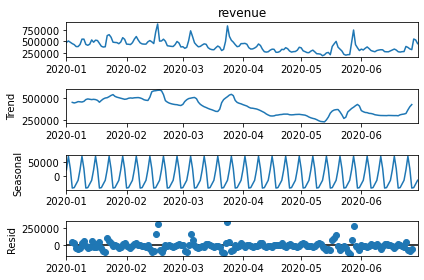

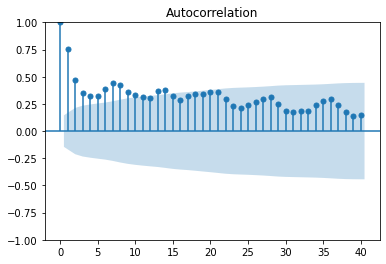

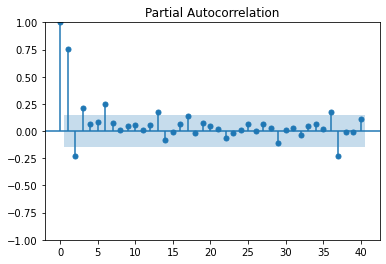

In [81]:
acf_pacf_plot(df_ts["revenue"])


In [20]:
adf_kpss_test(df_ts["revenue"])


ADF Statistic: -2.52
Critial Values:
   1%, -3.47
Critial Values:
   5%, -2.88
Critial Values:
   10%, -2.58

p-value: 0.11
Non-Stationary


KPSS Statistic: 1.52
Critial Values:
   10%, 0.35
Critial Values:
   5%, 0.46
Critial Values:
   2.5%, 0.57
Critial Values:
   1%, 0.74

p-value: 0.01
Non-Stationary


E:\Tolu\PROGRAMS\Anaconda2\lib\site-packages\statsmodels\tsa\stattools.py:2019: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




<AxesSubplot:xlabel='date'>

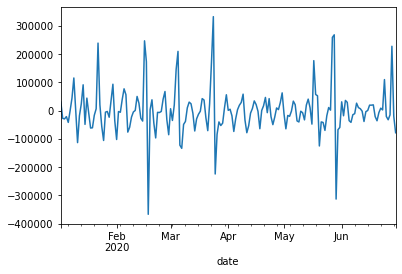

In [82]:
df_ts["rev_diff"] = df_ts["revenue"] - df_ts["revenue"].shift(1)
df_ts["rev_diff"].dropna().plot()


<AxesSubplot:xlabel='date'>

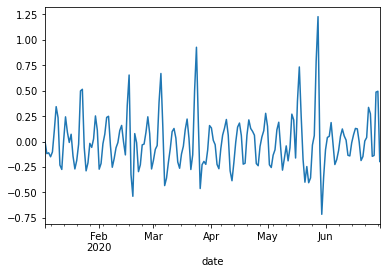

In [83]:
df_ts["rev_log"] = np.log(df_ts["revenue"])
df_ts["rev_log_diff"] = df_ts["rev_log"] - df_ts["rev_log"].shift(2)
df_ts["rev_log_diff"].dropna().plot()


In [84]:
adf_kpss_test(df_ts["rev_log_diff"])


ADF Statistic: -6.34
Critial Values:
   1%, -3.47
Critial Values:
   5%, -2.88
Critial Values:
   10%, -2.58

p-value: 0.00
Stationary


KPSS Statistic: 0.15
Critial Values:
   10%, 0.35
Critial Values:
   5%, 0.46
Critial Values:
   2.5%, 0.57
Critial Values:
   1%, 0.74

p-value: 0.10
Stationary


E:\Tolu\PROGRAMS\Anaconda2\lib\site-packages\statsmodels\tsa\stattools.py:2023: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




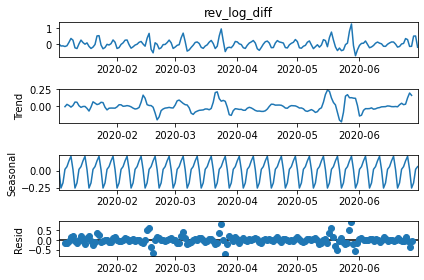

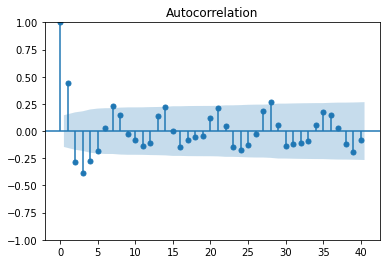

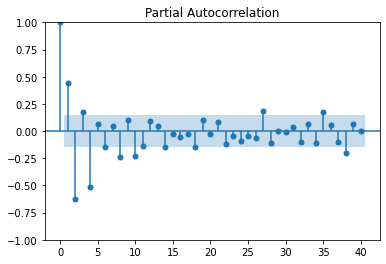

In [85]:
acf_pacf_plot(df_ts["rev_log_diff"].dropna())


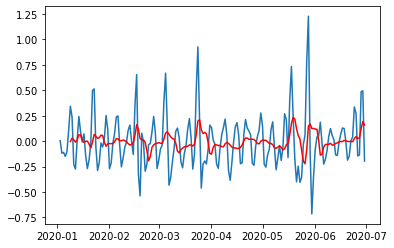

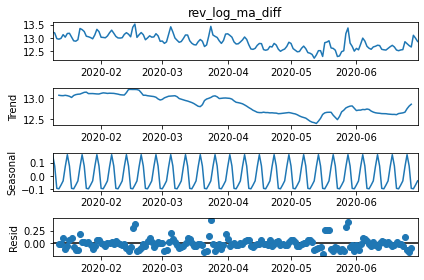

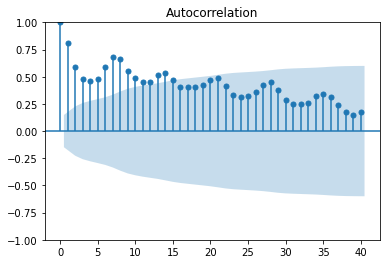

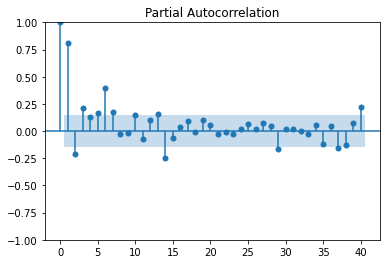

ADF Statistic: -1.56
Critial Values:
   1%, -3.47
Critial Values:
   5%, -2.88
Critial Values:
   10%, -2.58

p-value: 0.50
Non-Stationary


KPSS Statistic: 1.56
Critial Values:
   10%, 0.35
Critial Values:
   5%, 0.46
Critial Values:
   2.5%, 0.57
Critial Values:
   1%, 0.74

p-value: 0.01
Non-Stationary


E:\Tolu\PROGRAMS\Anaconda2\lib\site-packages\statsmodels\tsa\stattools.py:2019: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




In [86]:
moving_avg = df_ts["rev_log_diff"].rolling(7).mean()
plt.plot(df_ts["rev_log_diff"])
plt.plot(moving_avg, color="red")

df_ts["rev_log_ma_diff"] = df_ts["rev_log"] - moving_avg
acf_pacf_plot(df_ts["rev_log_ma_diff"].dropna())

adf_kpss_test(df_ts["rev_log_ma_diff"].dropna())


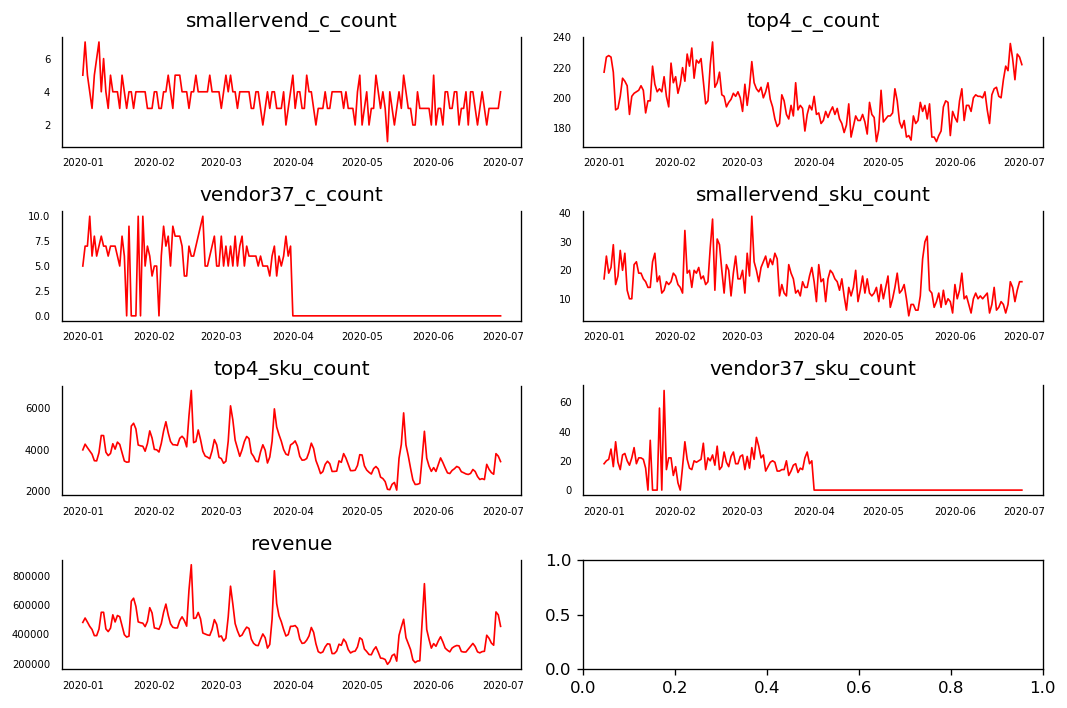

In [87]:
cols = [
    x
    for x in df_ts.columns.tolist()
    if not "rev" in x and x not in ["smallervend", "top4vend", "vendor37"]
]
cols = cols + ["revenue"]
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(9, 6))
for i, ax in enumerate(np.delete(axes.flatten(), 7)):
    data = df_ts[cols[i]]
    ax.plot(data, color="red", linewidth=1)
    ax.set_title(cols[i])
    ax.xaxis.set_ticks_position("none")
    ax.yaxis.set_ticks_position("none")
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)
plt.tight_layout()


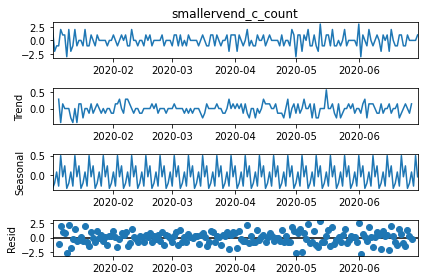

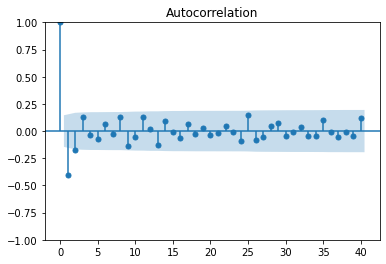

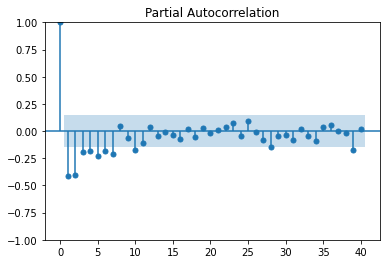

ADF Statistic: -7.06
Critial Values:
   1%, -3.47
Critial Values:
   5%, -2.88
Critial Values:
   10%, -2.58

p-value: 0.00
Stationary


KPSS Statistic: 0.13
Critial Values:
   10%, 0.35
Critial Values:
   5%, 0.46
Critial Values:
   2.5%, 0.57
Critial Values:
   1%, 0.74

p-value: 0.10
Stationary


E:\Tolu\PROGRAMS\Anaconda2\lib\site-packages\statsmodels\tsa\stattools.py:2023: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




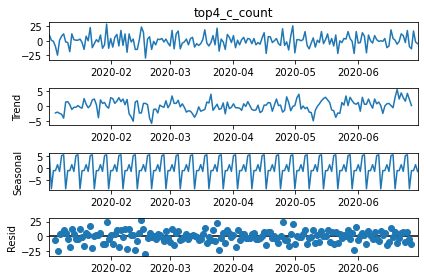

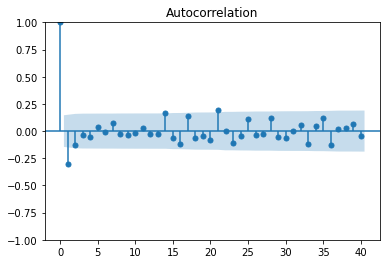

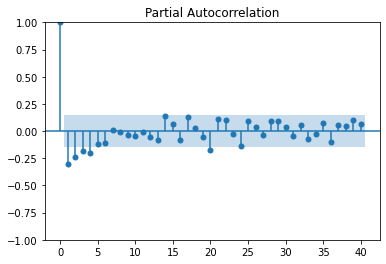

ADF Statistic: -8.66
Critial Values:
   1%, -3.47
Critial Values:
   5%, -2.88
Critial Values:
   10%, -2.58

p-value: 0.00
Stationary


KPSS Statistic: 0.31
Critial Values:
   10%, 0.35
Critial Values:
   5%, 0.46
Critial Values:
   2.5%, 0.57
Critial Values:
   1%, 0.74

p-value: 0.10
Stationary


E:\Tolu\PROGRAMS\Anaconda2\lib\site-packages\statsmodels\tsa\stattools.py:2023: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




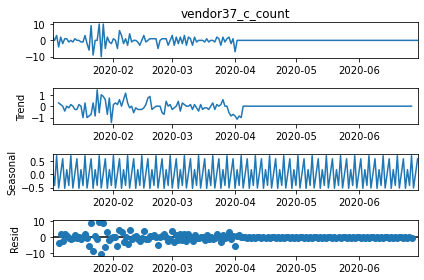

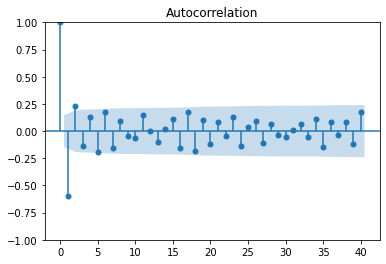

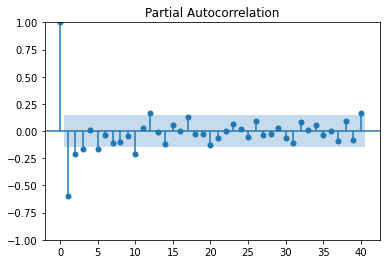

ADF Statistic: -4.50
Critial Values:
   1%, -3.47
Critial Values:
   5%, -2.88
Critial Values:
   10%, -2.58

p-value: 0.00
Stationary


KPSS Statistic: 0.27
Critial Values:
   10%, 0.35
Critial Values:
   5%, 0.46
Critial Values:
   2.5%, 0.57
Critial Values:
   1%, 0.74

p-value: 0.10
Stationary


E:\Tolu\PROGRAMS\Anaconda2\lib\site-packages\statsmodels\tsa\stattools.py:2023: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




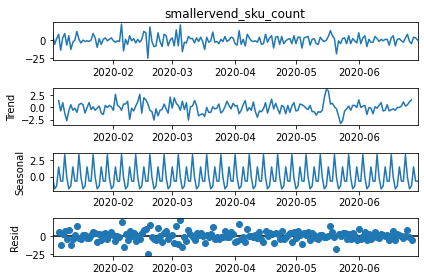

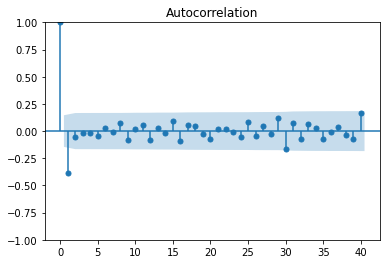

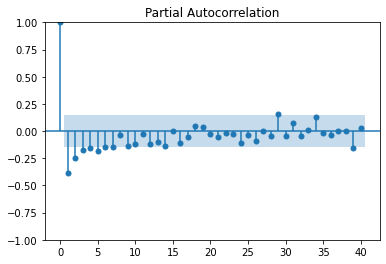

ADF Statistic: -8.48
Critial Values:
   1%, -3.47
Critial Values:
   5%, -2.88
Critial Values:
   10%, -2.58

p-value: 0.00
Stationary


KPSS Statistic: 0.14
Critial Values:
   10%, 0.35
Critial Values:
   5%, 0.46
Critial Values:
   2.5%, 0.57
Critial Values:
   1%, 0.74

p-value: 0.10
Stationary


E:\Tolu\PROGRAMS\Anaconda2\lib\site-packages\statsmodels\tsa\stattools.py:2023: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




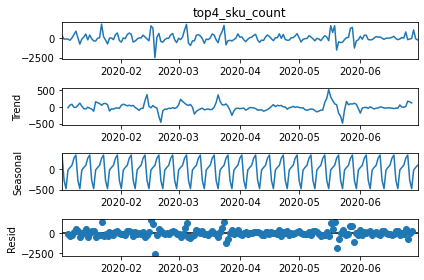

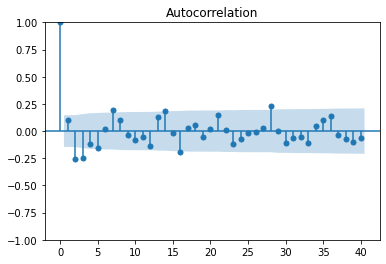

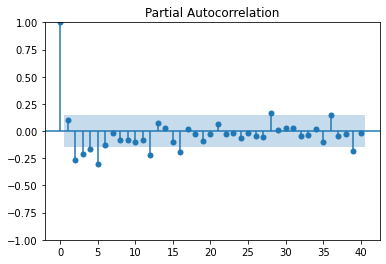

ADF Statistic: -6.87
Critial Values:
   1%, -3.47
Critial Values:
   5%, -2.88
Critial Values:
   10%, -2.58

p-value: 0.00
Stationary


KPSS Statistic: 0.12
Critial Values:
   10%, 0.35
Critial Values:
   5%, 0.46
Critial Values:
   2.5%, 0.57
Critial Values:
   1%, 0.74

p-value: 0.10
Stationary


E:\Tolu\PROGRAMS\Anaconda2\lib\site-packages\statsmodels\tsa\stattools.py:2023: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




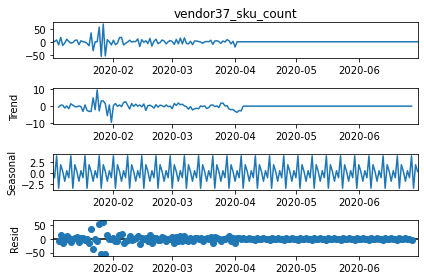

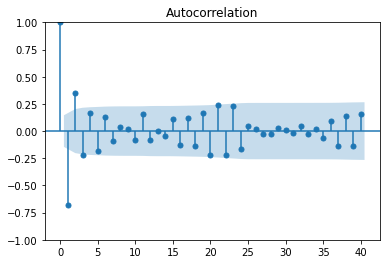

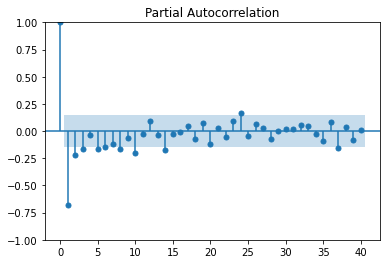

ADF Statistic: -7.66
Critial Values:
   1%, -3.47
Critial Values:
   5%, -2.88
Critial Values:
   10%, -2.58

p-value: 0.00
Stationary


KPSS Statistic: 0.10
Critial Values:
   10%, 0.35
Critial Values:
   5%, 0.46
Critial Values:
   2.5%, 0.57
Critial Values:
   1%, 0.74

p-value: 0.10
Stationary


E:\Tolu\PROGRAMS\Anaconda2\lib\site-packages\statsmodels\tsa\stattools.py:2023: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




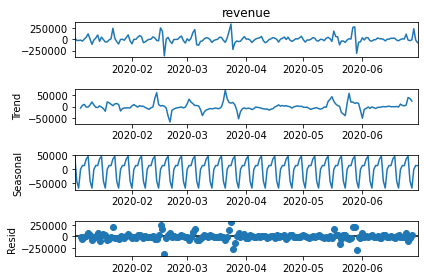

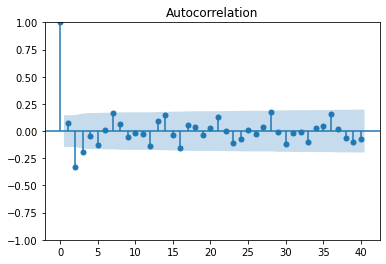

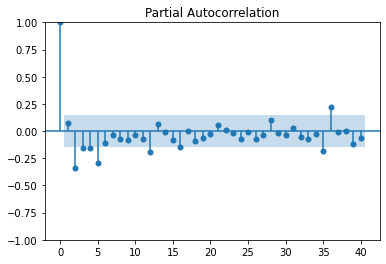

ADF Statistic: -10.35
Critial Values:
   1%, -3.47
Critial Values:
   5%, -2.88
Critial Values:
   10%, -2.58

p-value: 0.00
Stationary


KPSS Statistic: 0.18
Critial Values:
   10%, 0.35
Critial Values:
   5%, 0.46
Critial Values:
   2.5%, 0.57
Critial Values:
   1%, 0.74

p-value: 0.10
Stationary


E:\Tolu\PROGRAMS\Anaconda2\lib\site-packages\statsmodels\tsa\stattools.py:2023: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




In [95]:
cols = [
    x
    for x in df_ts.columns.tolist()
    if not "rev" in x and x not in ["smallervend", "top4vend", "vendor37"]
]
cols = cols + ["revenue"]
for col in cols:
    acf_pacf_plot(df_ts[col].diff()[1:])
    adf_kpss_test(df_ts[col].diff()[1:])


In [96]:
cols = [
    x
    for x in df_ts.columns.tolist()
    if not "rev" in x and x not in ["smallervend", "top4vend", "vendor37"]
]
cols = cols + ["revenue"]
df_vtrain = df_ts[cols].loc[df_ts.index <= "2020-03-31"]
df_vtest = df_ts[cols].loc[df_ts.index > "2020-03-31"]


In [97]:
from statsmodels.tsa.vector_ar.var_model import VAR

model = VAR(df_vtrain.diff()[1:])
sorted_order = model.select_order(maxlags=5)
print(sorted_order.summary())


E:\Tolu\PROGRAMS\Anaconda2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



In [100]:
from statsmodels.tsa.statespace.varmax import VARMAX

var_model = VARMAX(df_vtrain, order=(1, 0), enforce_stationarity=True)
fitted_mod = var_model.fit(disp=False)
print(fitted_mod.summary())


E:\Tolu\PROGRAMS\Anaconda2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Tolu\PROGRAMS\Anaconda2\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                                                                                      Statespace Model Results                                                                                     
Dep. Variable:     ['smallervend_c_count', 'top4_c_count', 'vendor37_c_count', 'smallervend_sku_count', 'top4_sku_count', 'vendor37_sku_count', 'revenue']   No. Observations:                   91
Model:                                                                                                                                              VAR(1)   Log Likelihood               -2906.398
                                                                                                                                               + intercept   AIC                           5980.797
Date:                                                                                                                                     Mon, 18 Apr 2022   BIC                           6191.709
Time:               

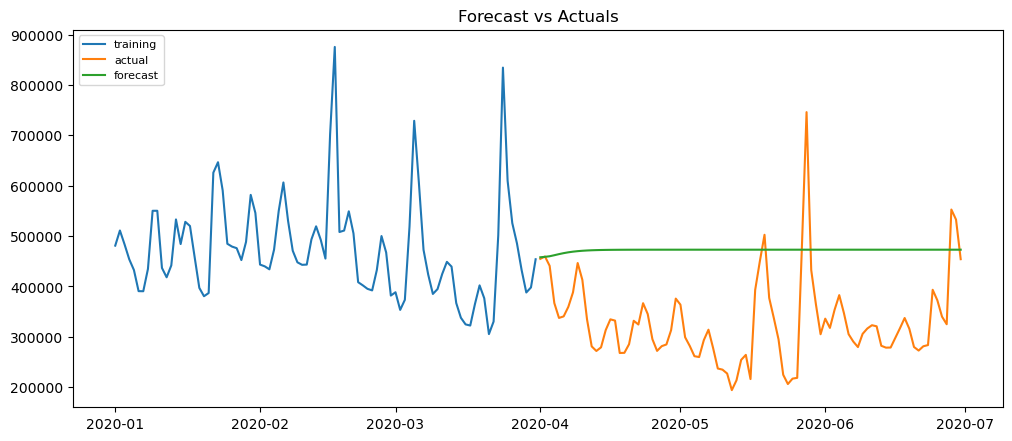

In [103]:
n_forecast = 91
predict = fitted_mod.get_prediction(
    start=len(df_vtrain), end=len(df_vtrain) + n_forecast - 1
)

predictions = predict.predicted_mean

df_vtest["rev_pred"] = predictions["revenue"]
plt.figure(figsize=(12, 5), dpi=100)
plt.plot(df_ts["revenue"].loc[df_ts.index <= "2020-03-31"], label="training")
plt.plot(df_ts["revenue"].loc[df_ts.index > "2020-03-31"], label="actual")
plt.plot(df_vtest["rev_pred"], label="forecast")
# plt.fill_between(lower_series.index, lower_series, upper_series,
#                  color='k', alpha=.15)
plt.title("Forecast vs Actuals")
plt.legend(loc="upper left", fontsize=8)
plt.show()


### Model Approach 

I initially wanted to address the question from a time series perspective, as I believe that revenue and transactions from prior days could have an impact on the future revenue forecast. I built a VAR (vector autoregression) model, for multivariate times series. However, a key assumption of VAR models is that you are predicting multiple time series variables using a single model. It effectively created a multiple univariate time series models for the predictors and response variable. It did not use the predictors to determine revenue. This model was not appropriate for this particular use case and effectively predicted Q2 revenue to be the mean of Q1 revenue. Please see the supplementary material for information about VAR model build. 

My next approach was a LSTM (Long Short-Term Memory) model. LSTM is a type of RNN (recurrent neural network) that uses past information to predict future outcomes. You are able to determine how many days in the past should be used to determine one day in the future. However, the drawback of this model in our current use case was that we did not have enough data for it to be effective. The days used to predict one day in the future would not be assigned a prediction themselves. Meaning if we used 20 days to predict one day in the future, those 20 days would not have a predicted revenue attached to them. Thus, our predictions would start from April 21 rather than April 1st. Not an ideal model for this use case and performance was not great. Please see the supplementary material for information about LSTM model build. 

I decided to visit more simpler approaches and ignored the dates; effectively treating the question here has a typical regression problem. I fitted the train dataset to simple linear model and saw greater success with it than those of the prior models. The $R^2$ value for the train and test dataset were 0.91 and 0.67 respectively. I created a second test dataset based on the hypothetical that vendor 37 did not close in Q2. This scored a $R^2$ of 0.68. 

Following these results I decided to try to the data with nonlinear models such as KNN and SVR. I used grid search to determine the optimal hyperparameter tuning. What I found was that SVR was the best performing model with the following $R^2$ score:  
Training R-Squared score: 0.81  
Test1 R-squared score: 0.78  
Test2 R-squared test score: 0.78  

These three regression models support the initial conclusion made in the general analysis. Vendor 37's impact was negligible in Q1 and would have been negligible in Q2. It's presence had no no real impact on revenue in Q2. There was no noticeable difference in the predictions made by the models when vendor 37 was closed in Q2 or if it was open in Q2.  

In [104]:
cols = [x for x in df_ts.columns.tolist() if not "rev" in x]
cols = ["revenue"] + cols
df_train3 = df_ts[cols].loc[df_ts.index <= "2020-03-31"]
df_test3 = df_ts[cols].loc[df_ts.index > "2020-03-31"]


In [105]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import *
from keras.callbacks import ModelCheckpoint
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from keras.models import load_model


In [106]:
scaler = StandardScaler()


def df_transform(df, window_size):
    df_as_np = df.to_numpy()
    df_as_np = scaler.fit_transform(df_as_np)
    X = []
    y = []
    for i in range(len(df_as_np) - window_size):
        row = [r for r in df_as_np[i : i + window_size]]
        X.append(row)
        label = df_as_np[i + window_size][0]
        y.append(label)
    return np.array(X), np.array(y)


time_step = 20
trainX, trainY = df_transform(df_train3, time_step)
testX, testY = df_transform(df_test3, time_step)
print(trainX.shape, trainY.shape, testX.shape, testY.shape)


(71, 20, 10) (71,) (71, 20, 10) (71,)


In [107]:
# best model
from numpy.random import seed
import tensorflow as tf

seed(1)
tf.random.set_seed(2)

mod3 = Sequential()
mod3.add(InputLayer((time_step, 10)))
mod3.add(LSTM(8, activation="tanh", return_sequences=True))
mod3.add(LSTM(4, activation="tanh", return_sequences=False))
mod3.add(Dropout(0.4))
mod3.add(Dense(1))

mod3.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 20, 8)             608       
                                                                 
 lstm_3 (LSTM)               (None, 4)                 208       
                                                                 
 dropout_1 (Dropout)         (None, 4)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 5         
                                                                 
Total params: 821
Trainable params: 821
Non-trainable params: 0
_________________________________________________________________


In [108]:
cp = ModelCheckpoint("mod3/", save_best_only=True)
mod3.compile(
    loss=MeanSquaredError(),
    optimizer=Adam(learning_rate=0.0001),
    metrics=[RootMeanSquaredError()],
)

seed(1)
tf.random.set_seed(2)

hist = mod3.fit(
    trainX,
    trainY,
    epochs=100,
    batch_size=20,
    validation_split=0.2,
    callbacks=[cp],
    shuffle=False,
)

mod3 = load_model("mod3/")


Epoch 1/100
1/3 [=========>....................] - ETA: 10s - loss: 0.7548 - root_mean_squared_error: 0.8688

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 12s 3s/step - loss: 1.0127 - root_mean_squared_error: 1.0063 - val_loss: 1.7715 - val_root_mean_squared_error: 1.3310
Epoch 2/100
1/3 [=========>....................] - ETA: 0s - loss: 0.8214 - root_mean_squared_error: 0.9063

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 6s 3s/step - loss: 1.1021 - root_mean_squared_error: 1.0498 - val_loss: 1.7714 - val_root_mean_squared_error: 1.3309
Epoch 3/100
1/3 [=========>....................] - ETA: 0s - loss: 0.8790 - root_mean_squared_error: 0.9376

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 6s 3s/step - loss: 1.1100 - root_mean_squared_error: 1.0536 - val_loss: 1.7713 - val_root_mean_squared_error: 1.3309
Epoch 4/100
1/3 [=========>....................] - ETA: 0s - loss: 0.7242 - root_mean_squared_error: 0.8510

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 6s 3s/step - loss: 1.0013 - root_mean_squared_error: 1.0006 - val_loss: 1.7711 - val_root_mean_squared_error: 1.3308
Epoch 5/100
1/3 [=========>....................] - ETA: 0s - loss: 0.6217 - root_mean_squared_error: 0.7885

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 6s 3s/step - loss: 0.9845 - root_mean_squared_error: 0.9922 - val_loss: 1.7709 - val_root_mean_squared_error: 1.3308
Epoch 6/100
1/3 [=========>....................] - ETA: 0s - loss: 0.6952 - root_mean_squared_error: 0.8338

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 6s 3s/step - loss: 1.0564 - root_mean_squared_error: 1.0278 - val_loss: 1.7708 - val_root_mean_squared_error: 1.3307
Epoch 7/100
1/3 [=========>....................] - ETA: 0s - loss: 0.7177 - root_mean_squared_error: 0.8471

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 6s 3s/step - loss: 1.0900 - root_mean_squared_error: 1.0440 - val_loss: 1.7706 - val_root_mean_squared_error: 1.3306
Epoch 8/100
1/3 [=========>....................] - ETA: 0s - loss: 0.8521 - root_mean_squared_error: 0.9231

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 6s 3s/step - loss: 1.1206 - root_mean_squared_error: 1.0586 - val_loss: 1.7704 - val_root_mean_squared_error: 1.3306
Epoch 9/100
1/3 [=========>....................] - ETA: 0s - loss: 0.8476 - root_mean_squared_error: 0.9206

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 6s 3s/step - loss: 1.0796 - root_mean_squared_error: 1.0390 - val_loss: 1.7703 - val_root_mean_squared_error: 1.3305
Epoch 10/100
1/3 [=========>....................] - ETA: 0s - loss: 0.6503 - root_mean_squared_error: 0.8064

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 6s 3s/step - loss: 1.0254 - root_mean_squared_error: 1.0126 - val_loss: 1.7701 - val_root_mean_squared_error: 1.3305
Epoch 11/100
1/3 [=========>....................] - ETA: 0s - loss: 0.7117 - root_mean_squared_error: 0.8436

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 5s 3s/step - loss: 0.9821 - root_mean_squared_error: 0.9910 - val_loss: 1.7700 - val_root_mean_squared_error: 1.3304
Epoch 12/100
1/3 [=========>....................] - ETA: 0s - loss: 0.8003 - root_mean_squared_error: 0.8946

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 6s 3s/step - loss: 1.0482 - root_mean_squared_error: 1.0238 - val_loss: 1.7698 - val_root_mean_squared_error: 1.3304
Epoch 13/100
1/3 [=========>....................] - ETA: 0s - loss: 0.7040 - root_mean_squared_error: 0.8390

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 6s 3s/step - loss: 0.9936 - root_mean_squared_error: 0.9968 - val_loss: 1.7697 - val_root_mean_squared_error: 1.3303
Epoch 14/100
1/3 [=========>....................] - ETA: 0s - loss: 0.7036 - root_mean_squared_error: 0.8388

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 6s 3s/step - loss: 1.0033 - root_mean_squared_error: 1.0016 - val_loss: 1.7696 - val_root_mean_squared_error: 1.3302
Epoch 15/100
1/3 [=========>....................] - ETA: 0s - loss: 0.6016 - root_mean_squared_error: 0.7756

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 6s 3s/step - loss: 1.0025 - root_mean_squared_error: 1.0012 - val_loss: 1.7694 - val_root_mean_squared_error: 1.3302
Epoch 16/100
1/3 [=========>....................] - ETA: 0s - loss: 0.7328 - root_mean_squared_error: 0.8561

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 6s 3s/step - loss: 1.0265 - root_mean_squared_error: 1.0131 - val_loss: 1.7693 - val_root_mean_squared_error: 1.3301
Epoch 17/100
1/3 [=========>....................] - ETA: 0s - loss: 0.7371 - root_mean_squared_error: 0.8586

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 6s 3s/step - loss: 1.0998 - root_mean_squared_error: 1.0487 - val_loss: 1.7691 - val_root_mean_squared_error: 1.3301
Epoch 18/100
1/3 [=========>....................] - ETA: 0s - loss: 0.6632 - root_mean_squared_error: 0.8144

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 6s 3s/step - loss: 1.0446 - root_mean_squared_error: 1.0221 - val_loss: 1.7689 - val_root_mean_squared_error: 1.3300
Epoch 19/100
1/3 [=========>....................] - ETA: 0s - loss: 0.6534 - root_mean_squared_error: 0.8083

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 6s 3s/step - loss: 0.9489 - root_mean_squared_error: 0.9741 - val_loss: 1.7688 - val_root_mean_squared_error: 1.3300
Epoch 20/100
1/3 [=========>....................] - ETA: 0s - loss: 0.7705 - root_mean_squared_error: 0.8778

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 5s 3s/step - loss: 1.0712 - root_mean_squared_error: 1.0350 - val_loss: 1.7686 - val_root_mean_squared_error: 1.3299
Epoch 21/100
1/3 [=========>....................] - ETA: 0s - loss: 0.8339 - root_mean_squared_error: 0.9132

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 7s 3s/step - loss: 1.0354 - root_mean_squared_error: 1.0175 - val_loss: 1.7685 - val_root_mean_squared_error: 1.3298
Epoch 22/100
1/3 [=========>....................] - ETA: 0s - loss: 0.7017 - root_mean_squared_error: 0.8377

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 6s 3s/step - loss: 0.9956 - root_mean_squared_error: 0.9978 - val_loss: 1.7683 - val_root_mean_squared_error: 1.3298
Epoch 23/100
1/3 [=========>....................] - ETA: 0s - loss: 0.6381 - root_mean_squared_error: 0.7988

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 6s 3s/step - loss: 0.9745 - root_mean_squared_error: 0.9872 - val_loss: 1.7682 - val_root_mean_squared_error: 1.3297
Epoch 24/100
1/3 [=========>....................] - ETA: 0s - loss: 0.7512 - root_mean_squared_error: 0.8667

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 6s 3s/step - loss: 1.0063 - root_mean_squared_error: 1.0032 - val_loss: 1.7681 - val_root_mean_squared_error: 1.3297
Epoch 25/100
1/3 [=========>....................] - ETA: 0s - loss: 0.7229 - root_mean_squared_error: 0.8502

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 7s 3s/step - loss: 1.0357 - root_mean_squared_error: 1.0177 - val_loss: 1.7680 - val_root_mean_squared_error: 1.3296
Epoch 26/100
1/3 [=========>....................] - ETA: 0s - loss: 0.7629 - root_mean_squared_error: 0.8735

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 6s 3s/step - loss: 1.0344 - root_mean_squared_error: 1.0170 - val_loss: 1.7678 - val_root_mean_squared_error: 1.3296
Epoch 27/100
1/3 [=========>....................] - ETA: 0s - loss: 0.5294 - root_mean_squared_error: 0.7276

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 6s 3s/step - loss: 0.9277 - root_mean_squared_error: 0.9632 - val_loss: 1.7677 - val_root_mean_squared_error: 1.3295
Epoch 28/100
1/3 [=========>....................] - ETA: 0s - loss: 0.6383 - root_mean_squared_error: 0.7989

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 6s 3s/step - loss: 0.9972 - root_mean_squared_error: 0.9986 - val_loss: 1.7676 - val_root_mean_squared_error: 1.3295
Epoch 29/100
1/3 [=========>....................] - ETA: 0s - loss: 0.7599 - root_mean_squared_error: 0.8717

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 6s 3s/step - loss: 1.0097 - root_mean_squared_error: 1.0048 - val_loss: 1.7674 - val_root_mean_squared_error: 1.3295
Epoch 30/100
1/3 [=========>....................] - ETA: 0s - loss: 0.7075 - root_mean_squared_error: 0.8411

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 6s 3s/step - loss: 1.0362 - root_mean_squared_error: 1.0179 - val_loss: 1.7673 - val_root_mean_squared_error: 1.3294
Epoch 31/100
1/3 [=========>....................] - ETA: 0s - loss: 0.6022 - root_mean_squared_error: 0.7760

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 7s 3s/step - loss: 0.9937 - root_mean_squared_error: 0.9968 - val_loss: 1.7672 - val_root_mean_squared_error: 1.3294
Epoch 32/100
1/3 [=========>....................] - ETA: 0s - loss: 0.7321 - root_mean_squared_error: 0.8556

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 6s 3s/step - loss: 0.9840 - root_mean_squared_error: 0.9920 - val_loss: 1.7671 - val_root_mean_squared_error: 1.3293
Epoch 33/100
1/3 [=========>....................] - ETA: 0s - loss: 0.6481 - root_mean_squared_error: 0.8051

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 6s 3s/step - loss: 1.0036 - root_mean_squared_error: 1.0018 - val_loss: 1.7670 - val_root_mean_squared_error: 1.3293
Epoch 34/100
1/3 [=========>....................] - ETA: 0s - loss: 0.7211 - root_mean_squared_error: 0.8492

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 6s 3s/step - loss: 0.9556 - root_mean_squared_error: 0.9776 - val_loss: 1.7668 - val_root_mean_squared_error: 1.3292
Epoch 35/100
1/3 [=========>....................] - ETA: 0s - loss: 0.8210 - root_mean_squared_error: 0.9061

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 6s 3s/step - loss: 1.0601 - root_mean_squared_error: 1.0296 - val_loss: 1.7667 - val_root_mean_squared_error: 1.3292
Epoch 36/100
1/3 [=========>....................] - ETA: 0s - loss: 0.6836 - root_mean_squared_error: 0.8268

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 6s 3s/step - loss: 0.9608 - root_mean_squared_error: 0.9802 - val_loss: 1.7666 - val_root_mean_squared_error: 1.3291
Epoch 37/100
1/3 [=========>....................] - ETA: 0s - loss: 0.6517 - root_mean_squared_error: 0.8073

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 6s 3s/step - loss: 0.9648 - root_mean_squared_error: 0.9822 - val_loss: 1.7664 - val_root_mean_squared_error: 1.3291
Epoch 38/100
1/3 [=========>....................] - ETA: 0s - loss: 0.7582 - root_mean_squared_error: 0.8707

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 6s 3s/step - loss: 0.9809 - root_mean_squared_error: 0.9904 - val_loss: 1.7663 - val_root_mean_squared_error: 1.3290
Epoch 39/100
1/3 [=========>....................] - ETA: 0s - loss: 0.7182 - root_mean_squared_error: 0.8474

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 6s 3s/step - loss: 0.9534 - root_mean_squared_error: 0.9764 - val_loss: 1.7662 - val_root_mean_squared_error: 1.3290
Epoch 40/100
1/3 [=========>....................] - ETA: 0s - loss: 0.7110 - root_mean_squared_error: 0.8432

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 6s 3s/step - loss: 1.0873 - root_mean_squared_error: 1.0427 - val_loss: 1.7660 - val_root_mean_squared_error: 1.3289
Epoch 41/100
1/3 [=========>....................] - ETA: 0s - loss: 0.6567 - root_mean_squared_error: 0.8104

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 6s 3s/step - loss: 0.9416 - root_mean_squared_error: 0.9704 - val_loss: 1.7659 - val_root_mean_squared_error: 1.3289
Epoch 42/100
1/3 [=========>....................] - ETA: 0s - loss: 0.7260 - root_mean_squared_error: 0.8520

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 5s 3s/step - loss: 1.0078 - root_mean_squared_error: 1.0039 - val_loss: 1.7658 - val_root_mean_squared_error: 1.3288
Epoch 43/100
1/3 [=========>....................] - ETA: 0s - loss: 0.5716 - root_mean_squared_error: 0.7560

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 7s 4s/step - loss: 0.9802 - root_mean_squared_error: 0.9901 - val_loss: 1.7657 - val_root_mean_squared_error: 1.3288
Epoch 44/100
1/3 [=========>....................] - ETA: 0s - loss: 0.7617 - root_mean_squared_error: 0.8728

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 7s 3s/step - loss: 1.0744 - root_mean_squared_error: 1.0365 - val_loss: 1.7655 - val_root_mean_squared_error: 1.3287
Epoch 45/100
1/3 [=========>....................] - ETA: 0s - loss: 0.6160 - root_mean_squared_error: 0.7848

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 6s 3s/step - loss: 0.9384 - root_mean_squared_error: 0.9687 - val_loss: 1.7654 - val_root_mean_squared_error: 1.3287
Epoch 46/100
1/3 [=========>....................] - ETA: 0s - loss: 0.7352 - root_mean_squared_error: 0.8574

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 6s 3s/step - loss: 0.9863 - root_mean_squared_error: 0.9931 - val_loss: 1.7653 - val_root_mean_squared_error: 1.3287
Epoch 47/100
1/3 [=========>....................] - ETA: 0s - loss: 0.8013 - root_mean_squared_error: 0.8952

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 6s 3s/step - loss: 1.0518 - root_mean_squared_error: 1.0256 - val_loss: 1.7652 - val_root_mean_squared_error: 1.3286
Epoch 48/100
1/3 [=========>....................] - ETA: 0s - loss: 0.7365 - root_mean_squared_error: 0.8582

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 6s 3s/step - loss: 1.0126 - root_mean_squared_error: 1.0063 - val_loss: 1.7651 - val_root_mean_squared_error: 1.3286
Epoch 49/100
1/3 [=========>....................] - ETA: 0s - loss: 0.8813 - root_mean_squared_error: 0.9388

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 6s 3s/step - loss: 1.0696 - root_mean_squared_error: 1.0342 - val_loss: 1.7650 - val_root_mean_squared_error: 1.3285
Epoch 50/100
1/3 [=========>....................] - ETA: 0s - loss: 0.5688 - root_mean_squared_error: 0.7542

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 6s 3s/step - loss: 0.9303 - root_mean_squared_error: 0.9645 - val_loss: 1.7649 - val_root_mean_squared_error: 1.3285
Epoch 51/100
1/3 [=========>....................] - ETA: 0s - loss: 0.7919 - root_mean_squared_error: 0.8899

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 5s 3s/step - loss: 1.0486 - root_mean_squared_error: 1.0240 - val_loss: 1.7647 - val_root_mean_squared_error: 1.3284
Epoch 52/100
1/3 [=========>....................] - ETA: 0s - loss: 0.6986 - root_mean_squared_error: 0.8358

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 6s 3s/step - loss: 1.0543 - root_mean_squared_error: 1.0268 - val_loss: 1.7646 - val_root_mean_squared_error: 1.3284
Epoch 53/100
1/3 [=========>....................] - ETA: 0s - loss: 0.6368 - root_mean_squared_error: 0.7980

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 6s 3s/step - loss: 0.9756 - root_mean_squared_error: 0.9877 - val_loss: 1.7644 - val_root_mean_squared_error: 1.3283
Epoch 54/100
1/3 [=========>....................] - ETA: 0s - loss: 0.7112 - root_mean_squared_error: 0.8434

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 7s 3s/step - loss: 1.0035 - root_mean_squared_error: 1.0017 - val_loss: 1.7643 - val_root_mean_squared_error: 1.3283
Epoch 55/100
1/3 [=========>....................] - ETA: 0s - loss: 0.6571 - root_mean_squared_error: 0.8106

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 6s 3s/step - loss: 0.9531 - root_mean_squared_error: 0.9763 - val_loss: 1.7642 - val_root_mean_squared_error: 1.3282
Epoch 56/100
1/3 [=========>....................] - ETA: 0s - loss: 0.6190 - root_mean_squared_error: 0.7868

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 5s 3s/step - loss: 0.9929 - root_mean_squared_error: 0.9964 - val_loss: 1.7640 - val_root_mean_squared_error: 1.3282
Epoch 57/100
1/3 [=========>....................] - ETA: 0s - loss: 0.6693 - root_mean_squared_error: 0.8181

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 6s 3s/step - loss: 0.9560 - root_mean_squared_error: 0.9778 - val_loss: 1.7639 - val_root_mean_squared_error: 1.3281
Epoch 58/100
1/3 [=========>....................] - ETA: 0s - loss: 0.6933 - root_mean_squared_error: 0.8326

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 6s 3s/step - loss: 0.9851 - root_mean_squared_error: 0.9925 - val_loss: 1.7638 - val_root_mean_squared_error: 1.3281
Epoch 59/100
1/3 [=========>....................] - ETA: 0s - loss: 0.6919 - root_mean_squared_error: 0.8318

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 6s 3s/step - loss: 0.9597 - root_mean_squared_error: 0.9796 - val_loss: 1.7637 - val_root_mean_squared_error: 1.3280
Epoch 60/100
1/3 [=========>....................] - ETA: 0s - loss: 0.6810 - root_mean_squared_error: 0.8252

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 6s 3s/step - loss: 0.9502 - root_mean_squared_error: 0.9748 - val_loss: 1.7636 - val_root_mean_squared_error: 1.3280
Epoch 61/100
1/3 [=========>....................] - ETA: 0s - loss: 0.5453 - root_mean_squared_error: 0.7385

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 6s 3s/step - loss: 0.9509 - root_mean_squared_error: 0.9751 - val_loss: 1.7635 - val_root_mean_squared_error: 1.3280
Epoch 62/100
1/3 [=========>....................] - ETA: 0s - loss: 0.7273 - root_mean_squared_error: 0.8528

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 6s 3s/step - loss: 1.0179 - root_mean_squared_error: 1.0089 - val_loss: 1.7634 - val_root_mean_squared_error: 1.3279
Epoch 63/100
1/3 [=========>....................] - ETA: 0s - loss: 0.6713 - root_mean_squared_error: 0.8194

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 6s 3s/step - loss: 0.9819 - root_mean_squared_error: 0.9909 - val_loss: 1.7633 - val_root_mean_squared_error: 1.3279
Epoch 64/100
1/3 [=========>....................] - ETA: 0s - loss: 0.6739 - root_mean_squared_error: 0.8209

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 7s 3s/step - loss: 0.9880 - root_mean_squared_error: 0.9940 - val_loss: 1.7632 - val_root_mean_squared_error: 1.3278
Epoch 65/100
1/3 [=========>....................] - ETA: 0s - loss: 0.7422 - root_mean_squared_error: 0.8615

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 6s 3s/step - loss: 1.0408 - root_mean_squared_error: 1.0202 - val_loss: 1.7631 - val_root_mean_squared_error: 1.3278
Epoch 66/100
1/3 [=========>....................] - ETA: 0s - loss: 0.7370 - root_mean_squared_error: 0.8585

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 6s 3s/step - loss: 0.9840 - root_mean_squared_error: 0.9920 - val_loss: 1.7629 - val_root_mean_squared_error: 1.3278
Epoch 67/100
1/3 [=========>....................] - ETA: 0s - loss: 0.7117 - root_mean_squared_error: 0.8436

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 6s 3s/step - loss: 1.0052 - root_mean_squared_error: 1.0026 - val_loss: 1.7628 - val_root_mean_squared_error: 1.3277
Epoch 68/100
1/3 [=========>....................] - ETA: 0s - loss: 0.6316 - root_mean_squared_error: 0.7947

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 6s 3s/step - loss: 1.0014 - root_mean_squared_error: 1.0007 - val_loss: 1.7627 - val_root_mean_squared_error: 1.3277
Epoch 69/100
1/3 [=========>....................] - ETA: 0s - loss: 0.7234 - root_mean_squared_error: 0.8505

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 6s 3s/step - loss: 0.9880 - root_mean_squared_error: 0.9940 - val_loss: 1.7625 - val_root_mean_squared_error: 1.3276
Epoch 70/100
1/3 [=========>....................] - ETA: 0s - loss: 0.6987 - root_mean_squared_error: 0.8359

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 6s 3s/step - loss: 1.0327 - root_mean_squared_error: 1.0162 - val_loss: 1.7624 - val_root_mean_squared_error: 1.3276
Epoch 71/100
1/3 [=========>....................] - ETA: 0s - loss: 0.6847 - root_mean_squared_error: 0.8275

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 6s 3s/step - loss: 0.9472 - root_mean_squared_error: 0.9732 - val_loss: 1.7623 - val_root_mean_squared_error: 1.3275
Epoch 72/100
1/3 [=========>....................] - ETA: 0s - loss: 0.7280 - root_mean_squared_error: 0.8532

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 6s 3s/step - loss: 1.0290 - root_mean_squared_error: 1.0144 - val_loss: 1.7622 - val_root_mean_squared_error: 1.3275
Epoch 73/100
1/3 [=========>....................] - ETA: 0s - loss: 0.7044 - root_mean_squared_error: 0.8393

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 6s 3s/step - loss: 1.0514 - root_mean_squared_error: 1.0254 - val_loss: 1.7620 - val_root_mean_squared_error: 1.3274
Epoch 74/100
1/3 [=========>....................] - ETA: 0s - loss: 0.7563 - root_mean_squared_error: 0.8697

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 6s 3s/step - loss: 1.0264 - root_mean_squared_error: 1.0131 - val_loss: 1.7619 - val_root_mean_squared_error: 1.3274
Epoch 75/100
1/3 [=========>....................] - ETA: 0s - loss: 0.6760 - root_mean_squared_error: 0.8222

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 7s 3s/step - loss: 1.0209 - root_mean_squared_error: 1.0104 - val_loss: 1.7618 - val_root_mean_squared_error: 1.3273
Epoch 76/100
1/3 [=========>....................] - ETA: 0s - loss: 0.6396 - root_mean_squared_error: 0.7998

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 6s 3s/step - loss: 1.0607 - root_mean_squared_error: 1.0299 - val_loss: 1.7616 - val_root_mean_squared_error: 1.3272
Epoch 77/100
1/3 [=========>....................] - ETA: 0s - loss: 0.7931 - root_mean_squared_error: 0.8906

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 7s 3s/step - loss: 1.0269 - root_mean_squared_error: 1.0134 - val_loss: 1.7614 - val_root_mean_squared_error: 1.3272
Epoch 78/100
1/3 [=========>....................] - ETA: 0s - loss: 0.5847 - root_mean_squared_error: 0.7647

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 6s 3s/step - loss: 0.9621 - root_mean_squared_error: 0.9808 - val_loss: 1.7612 - val_root_mean_squared_error: 1.3271
Epoch 79/100
1/3 [=========>....................] - ETA: 0s - loss: 0.6511 - root_mean_squared_error: 0.8069

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 6s 3s/step - loss: 0.9716 - root_mean_squared_error: 0.9857 - val_loss: 1.7610 - val_root_mean_squared_error: 1.3270
Epoch 80/100
1/3 [=========>....................] - ETA: 0s - loss: 0.7030 - root_mean_squared_error: 0.8385

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 6s 3s/step - loss: 0.9801 - root_mean_squared_error: 0.9900 - val_loss: 1.7609 - val_root_mean_squared_error: 1.3270
Epoch 81/100
1/3 [=========>....................] - ETA: 0s - loss: 0.6654 - root_mean_squared_error: 0.8157

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 6s 3s/step - loss: 0.9943 - root_mean_squared_error: 0.9972 - val_loss: 1.7607 - val_root_mean_squared_error: 1.3269
Epoch 82/100
1/3 [=========>....................] - ETA: 0s - loss: 0.6859 - root_mean_squared_error: 0.8282

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 6s 3s/step - loss: 0.9720 - root_mean_squared_error: 0.9859 - val_loss: 1.7606 - val_root_mean_squared_error: 1.3269
Epoch 83/100
1/3 [=========>....................] - ETA: 0s - loss: 0.6652 - root_mean_squared_error: 0.8156

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 6s 3s/step - loss: 1.0302 - root_mean_squared_error: 1.0150 - val_loss: 1.7604 - val_root_mean_squared_error: 1.3268
Epoch 84/100
1/3 [=========>....................] - ETA: 0s - loss: 0.6284 - root_mean_squared_error: 0.7927

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 6s 3s/step - loss: 0.9615 - root_mean_squared_error: 0.9806 - val_loss: 1.7603 - val_root_mean_squared_error: 1.3268
Epoch 85/100
1/3 [=========>....................] - ETA: 0s - loss: 0.6876 - root_mean_squared_error: 0.8292

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 6s 3s/step - loss: 0.9870 - root_mean_squared_error: 0.9935 - val_loss: 1.7601 - val_root_mean_squared_error: 1.3267
Epoch 86/100
1/3 [=========>....................] - ETA: 0s - loss: 0.6828 - root_mean_squared_error: 0.8263

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 6s 3s/step - loss: 1.0115 - root_mean_squared_error: 1.0058 - val_loss: 1.7600 - val_root_mean_squared_error: 1.3267
Epoch 87/100
1/3 [=========>....................] - ETA: 0s - loss: 0.6419 - root_mean_squared_error: 0.8012

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 6s 3s/step - loss: 0.9941 - root_mean_squared_error: 0.9970 - val_loss: 1.7599 - val_root_mean_squared_error: 1.3266
Epoch 88/100
1/3 [=========>....................] - ETA: 0s - loss: 0.7347 - root_mean_squared_error: 0.8572

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 8s 4s/step - loss: 1.0473 - root_mean_squared_error: 1.0234 - val_loss: 1.7597 - val_root_mean_squared_error: 1.3265
Epoch 89/100
1/3 [=========>....................] - ETA: 0s - loss: 0.6288 - root_mean_squared_error: 0.7930

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 6s 3s/step - loss: 0.9444 - root_mean_squared_error: 0.9718 - val_loss: 1.7596 - val_root_mean_squared_error: 1.3265
Epoch 90/100
1/3 [=========>....................] - ETA: 0s - loss: 0.7093 - root_mean_squared_error: 0.8422

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 6s 3s/step - loss: 0.9778 - root_mean_squared_error: 0.9889 - val_loss: 1.7595 - val_root_mean_squared_error: 1.3264
Epoch 91/100
1/3 [=========>....................] - ETA: 0s - loss: 0.7617 - root_mean_squared_error: 0.8727

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 6s 3s/step - loss: 0.9647 - root_mean_squared_error: 0.9822 - val_loss: 1.7593 - val_root_mean_squared_error: 1.3264
Epoch 92/100
1/3 [=========>....................] - ETA: 0s - loss: 0.7134 - root_mean_squared_error: 0.8446

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 5s 3s/step - loss: 0.9933 - root_mean_squared_error: 0.9967 - val_loss: 1.7592 - val_root_mean_squared_error: 1.3264
Epoch 93/100
1/3 [=========>....................] - ETA: 0s - loss: 0.6635 - root_mean_squared_error: 0.8146

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 6s 3s/step - loss: 0.9700 - root_mean_squared_error: 0.9849 - val_loss: 1.7591 - val_root_mean_squared_error: 1.3263
Epoch 94/100
1/3 [=========>....................] - ETA: 0s - loss: 0.7492 - root_mean_squared_error: 0.8655

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 6s 3s/step - loss: 0.9472 - root_mean_squared_error: 0.9732 - val_loss: 1.7590 - val_root_mean_squared_error: 1.3263
Epoch 95/100
1/3 [=========>....................] - ETA: 0s - loss: 0.6069 - root_mean_squared_error: 0.7791

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 6s 3s/step - loss: 0.9803 - root_mean_squared_error: 0.9901 - val_loss: 1.7589 - val_root_mean_squared_error: 1.3262
Epoch 96/100
1/3 [=========>....................] - ETA: 0s - loss: 0.7584 - root_mean_squared_error: 0.8709

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 6s 3s/step - loss: 1.0068 - root_mean_squared_error: 1.0034 - val_loss: 1.7588 - val_root_mean_squared_error: 1.3262
Epoch 97/100
1/3 [=========>....................] - ETA: 0s - loss: 0.5493 - root_mean_squared_error: 0.7411

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 7s 4s/step - loss: 0.9184 - root_mean_squared_error: 0.9583 - val_loss: 1.7587 - val_root_mean_squared_error: 1.3262
Epoch 98/100
1/3 [=========>....................] - ETA: 0s - loss: 0.7047 - root_mean_squared_error: 0.8395

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 6s 3s/step - loss: 0.9847 - root_mean_squared_error: 0.9923 - val_loss: 1.7585 - val_root_mean_squared_error: 1.3261
Epoch 99/100
1/3 [=========>....................] - ETA: 0s - loss: 0.7092 - root_mean_squared_error: 0.8422

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 6s 3s/step - loss: 0.9835 - root_mean_squared_error: 0.9917 - val_loss: 1.7584 - val_root_mean_squared_error: 1.3261
Epoch 100/100
1/3 [=========>....................] - ETA: 0s - loss: 0.6826 - root_mean_squared_error: 0.8262

INFO:tensorflow:Assets written to: mod3\assets


INFO:tensorflow:Assets written to: mod3\assets


3/3 [==============================] - 6s 3s/step - loss: 0.9971 - root_mean_squared_error: 0.9985 - val_loss: 1.7583 - val_root_mean_squared_error: 1.3260


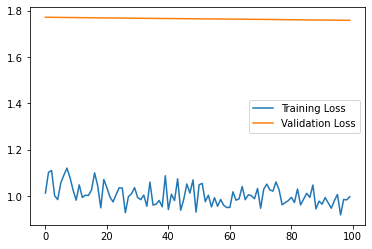

In [111]:
seed(1)
tf.random.set_seed(2)
plt.plot(hist.history["loss"], label="Training Loss")
plt.plot(hist.history["val_loss"], label="Validation Loss")
plt.legend()


In [112]:
test_pred = mod3.predict(testX)


def get_dates(y_pred, data, original_data):
    forecast_copies = np.repeat(y_pred, original_data.shape[1], axis=1)
    y_pred = scaler.inverse_transform(forecast_copies)[:, 0]
    df_forecast = pd.DataFrame(
        {"date": original_data.iloc[20:].index, "revenue": y_pred}
    )
    df_forecast["date"] = pd.to_datetime(df_forecast["date"])
    df_forecast = df_forecast.set_index("date")
    return df_forecast


y_pred_future = get_dates(test_pred, testX, df_test3)


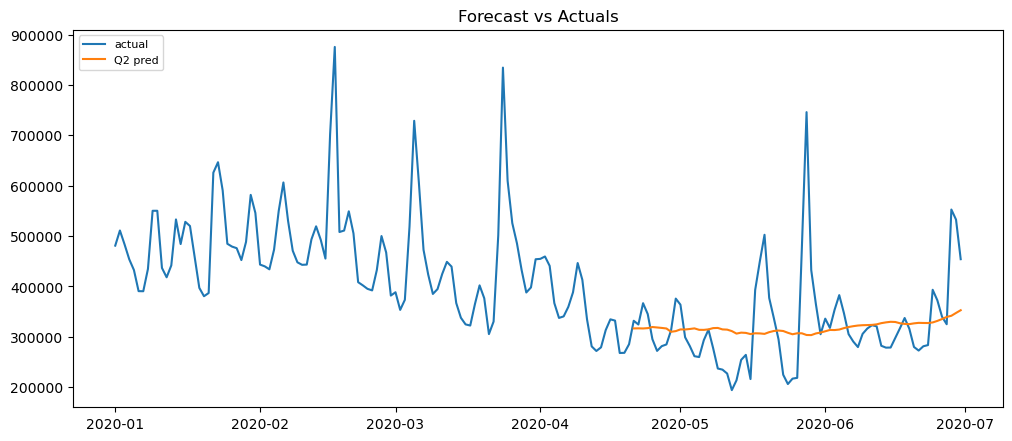

In [113]:
plt.figure(figsize=(12, 5), dpi=100)
plt.plot(df_ts["revenue"], label="actual")
plt.plot(y_pred_future, label="Q2 pred")
plt.title("Forecast vs Actuals")
plt.legend(loc="upper left", fontsize=8)
plt.show()


In [140]:
d2 = (
    d.groupby(["date", "vendor"])
    .agg({"sku": "sum", "country_code": "sum"})
    .reset_index()
)
d2["vendor"] = "top4vend"
d2 = (
    d2.groupby(["date", "vendor"])
    .agg({"sku": "sum", "country_code": "sum"})
    .reset_index()
)
d2 = d2.set_index("date")
temp = (
    df_pred_prob.groupby(["vendor", "quarter"])
    .agg({"vend_prob": "sum", "vend_prob2": "sum"})
    .reset_index()
)
new_prob = temp.loc[(temp["vendor"] == "top4vend") & (temp["quarter"] == "Q2")][
    "vend_prob2"
]


In [145]:
scaler = StandardScaler()
X_train = df_train3.iloc[:, 1:]
y_train = df_train3.iloc[:, 0]

X_test = df_test3.iloc[:, 1:]
X_test2 = X_test.copy()
X_test2["vendor37"] = df_pred.loc[(df_pred["date"] > "2020-03-31")][
    "vendor37"
].unique()[0]

X_test2[["vendor37_sku_count", "vendor37_c_count"]] = X_test2[
    ["vendor37_sku_count", "vendor37_c_count"]
].loc[X_test2.index.isin(d2.index)] = d2[["sku", "country_code"]]
X_test2.fillna(0, inplace=True)
X_test2["top4_c_count"] = X_test2["top4_c_count"] - X_test2["vendor37_c_count"]
X_test2["top4_sku_count"] = X_test2["top4_sku_count"] - X_test2["vendor37_sku_count"]
X_test2["vendor37"] = 58 / len(
    transactions.loc[transactions["quarter"] == "Q2"]["account"].unique()
)
X_test2["top4vend"] = new_prob.values[0]
y_test = df_test3.iloc[:, 0]

In [147]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression().fit(X_train, y_train)
print(f"The linear regression linear model intercept: {linreg.intercept_}")
print(f"coef values: {linreg.coef_}")
print(f"Training R-Squared score: {linreg.score(X_train, y_train)}")
print(f"Testing R-Squared score: {linreg.score(X_test, y_test)}")
print(f"Testing R-Squared score: {linreg.score(X_test2, y_test)}")
y_pred = linreg.predict(X_test)
y_pred2 = pd.Series(y_pred, index=y_test.index)
y_pred3 = linreg.predict(X_test2)
y_pred3 = pd.Series(y_pred3, index=y_test.index)
print(f"Number of non-zero coef: {np.sum(linreg.coef_!=0)}")


The linear regression linear model intercept: -203608.16267872514
coef values: [ 3.01575548e-24 -1.44245494e-05 -8.02355774e+06  1.08991909e+04
  2.42083155e+02 -1.00764392e+03 -1.14803174e+03  1.47532515e+02
  5.98046524e+02]
Training R-Squared score: 0.9092493989462195
Testing R-Squared score: 0.6697031606195131
Testing R-Squared score: 0.6760697857538892
Number of non-zero coef: 9


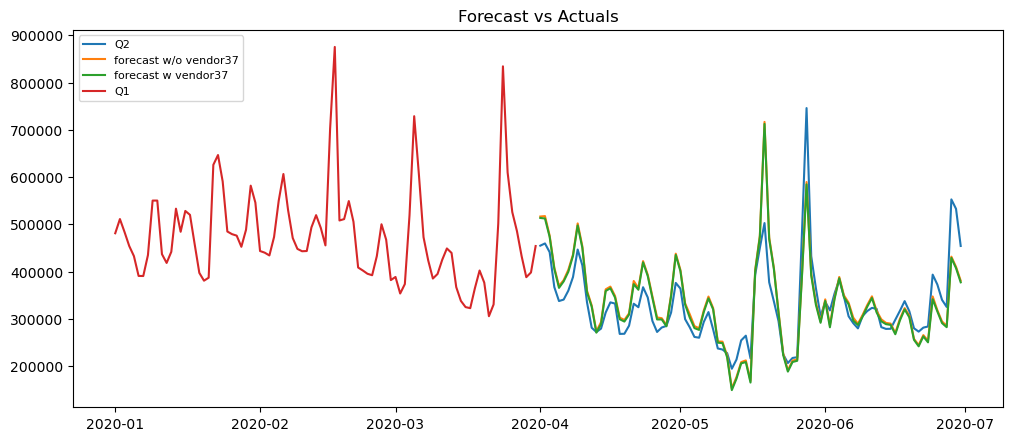

In [148]:
plt.figure(figsize=(12, 5), dpi=100)
plt.plot(y_test, label="Q2")
plt.plot(y_pred2, label="forecast w/o vendor37")
plt.plot(y_pred3, label="forecast w vendor37")
plt.plot(y_train, label="Q1")
plt.title("Forecast vs Actuals")
plt.legend(loc="upper left", fontsize=8)
plt.show()


In [134]:
from sklearn.neighbors import KNeighborsRegressor

seed(123)
knnreg = KNeighborsRegressor()
k = np.arange(1, 51)
gr_val = {"n_neighbors": k}
gr_reg_acc = GridSearchCV(knnreg, param_grid=gr_val)
gr_reg_acc.fit(X_train, y_train)
y_dec_fn_sco_acc = gr_reg_acc.fit(X_test, y_test)

print(f"Grid best parameter (max. accuracy): {gr_reg_acc.best_params_}")
print(f"Grid best score (accuracy): {gr_reg_acc.best_score_}")
print(f"Training R-Squared score: {gr_reg_acc.score(X_train, y_train)}")
print(f"R-squared test score: {gr_reg_acc.score(X_test, y_test)}")
print(f"R-squared test score: {gr_reg_acc.score(X_test2, y_test)}")
y_pred = gr_reg_acc.predict(X_test)
y_pred2 = pd.Series(y_pred, index=y_test.index)
y_pred3 = gr_reg_acc.predict(X_test2)
y_pred3 = pd.Series(y_pred3, index=y_test.index)


Grid best parameter (max. accuracy): {'n_neighbors': 14}
Grid best score (accuracy): 0.47692520591373916
Training R-Squared score: 0.05701979952903535
R-squared test score: 0.6752642091117036
R-squared test score: 0.6755086827414285


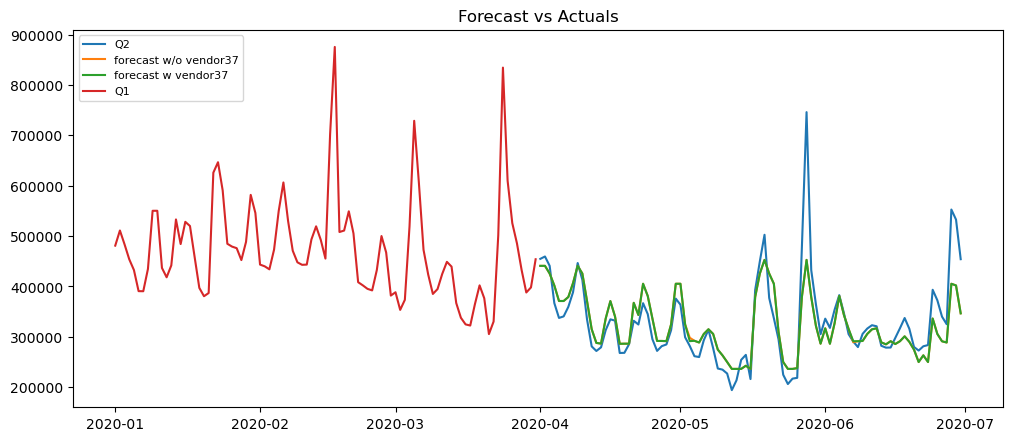

In [135]:
plt.figure(figsize=(12, 5), dpi=100)
plt.plot(y_test, label="Q2")
plt.plot(y_pred2, label="forecast w/o vendor37")
plt.plot(y_pred3, label="forecast w vendor37")
plt.plot(y_train, label="Q1")
plt.title("Forecast vs Actuals")
plt.legend(loc="upper left", fontsize=8)
plt.show()


In [136]:
from sklearn.svm import SVR

seed(123)
svrreg = SVR(gamma="auto")
C = np.arange(1, 51)
kernel = ["linear", "rbf"]

gr_val = {"C": C, "kernel": kernel}
gr_reg_acc = GridSearchCV(svrreg, param_grid=gr_val)
gr_reg_acc.fit(X_train, y_train)
y_dec_fn_sco_acc = gr_reg_acc.fit(X_test, y_test)

print(f"Grid best parameter (max. accuracy): {gr_reg_acc.best_params_}")
print(f"Grid best score (accuracy): {gr_reg_acc.best_score_}")
print(f"Training R-Squared score: {gr_reg_acc.score(X_train, y_train)}")
print(f"R-squared test score: {gr_reg_acc.score(X_test, y_test)}")
print(f"R-squared test score: {gr_reg_acc.score(X_test2, y_test)}")
y_pred = gr_reg_acc.predict(X_test)
y_pred2 = pd.Series(y_pred, index=y_test.index)
y_pred3 = gr_reg_acc.predict(X_test2)
y_pred3 = pd.Series(y_pred3, index=y_test.index)


Grid best parameter (max. accuracy): {'C': 17, 'kernel': 'linear'}
Grid best score (accuracy): 0.6957851033928095
Training R-Squared score: 0.805049770983329
R-squared test score: 0.784901809679436
R-squared test score: 0.7804336455957244


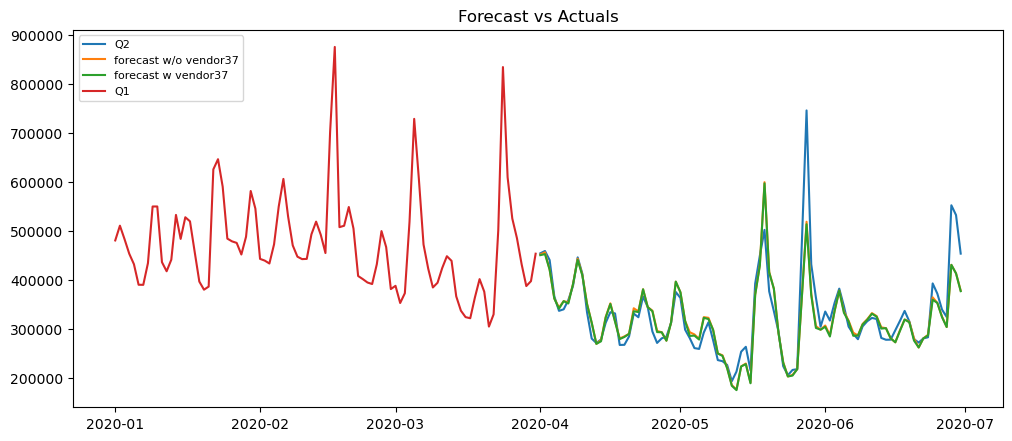

In [137]:
plt.figure(figsize=(12, 5), dpi=100)
plt.plot(y_test, label="Q2")
plt.plot(y_pred2, label="forecast w/o vendor37")
plt.plot(y_pred3, label="forecast w vendor37")
plt.plot(y_train, label="Q1")
plt.title("Forecast vs Actuals")
plt.legend(loc="upper left", fontsize=8)
plt.show()


In [139]:
df = (
    transactions.groupby(["date"])
    .agg(revenue=("revenue", "sum"), sku_count=("sku", "count"))
    .sort_values("date")
    .reset_index()
)

color = px.colors.sequential.Plasma[0]

line = go.Scatter(
    x=y_pred3.index, y=y_pred3, mode="lines", name="Q2 Predicted Revenue w vendor37"
)
line2 = go.Scatter(x=df["date"], y=df["revenue"], name="Actual Revenue", mode="lines")
line3 = go.Scatter(
    x=y_pred2.index, y=y_pred2, name="Q2 Predicted Revenue w/o vendor37", mode="lines"
)
fig = make_subplots(
    rows=1,
    cols=1,
    vertical_spacing=0,
    shared_xaxes=True,
)

fig.append_trace(line2, row=1, col=1)
fig.append_trace(line3, row=1, col=1)
fig.append_trace(line, row=1, col=1)

fig.update_yaxes(row=1, col=1, title_text="Revenue")
fig.update_xaxes(row=1, col=1)
fig.update_xaxes(row=1, col=1, title_text="Day")
fig.update_layout(title="Revenue Over Time (Days)")
fig.show()
